In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
# Configurations

n_3b = 250000
n_all4b = 250000
seed = 92

In [16]:
import pathlib
import pandas as pd
import numpy as np
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt

from events_data import EventsData

directory = pathlib.Path("../events/MG3")
df_3b = pd.read_hdf(directory / "dataframes" / "threeTag_picoAOD.h5")
df_3b = df_3b.sample(frac=1, random_state=seed).reset_index(drop=True)
df_3b = df_3b.iloc[:n_3b]

df_bg4b = pd.read_hdf(directory / "dataframes" / "fourTag_10x_picoAOD.h5")
df_bg4b = df_bg4b.sample(frac=1, random_state=seed).reset_index(drop=True)
df_bg4b = df_bg4b.iloc[:n_all4b]

df_signal = pd.read_hdf(directory / "dataframes" / "HH4b_picoAOD.h5")
df_signal = df_signal.sample(frac=1, random_state=seed).reset_index(drop=True)
df_signal = df_signal.iloc[:n_all4b]

df_3b["signal"] = False
df_bg4b["signal"] = False
df_signal["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_signal))


features = [
    "sym_Jet0_pt",
    "sym_Jet1_pt",
    "sym_Jet2_pt",
    "sym_Jet3_pt",
    "sym_Jet0_eta",
    "sym_Jet1_eta",
    "sym_Jet2_eta",
    "sym_Jet3_eta",
    "sym_Jet0_phi",
    "sym_Jet1_phi",
    "sym_Jet2_phi",
    "sym_Jet3_phi",
    "sym_Jet0_m",
    "sym_Jet1_m",
    "sym_Jet2_m",
    "sym_Jet3_m",
]

3b-jet events:  250000
4b-jet events:  250000
HH4b-jet events:  30856


In [17]:
signal_ratio = 0.02
four_tag_ratio = 0.5
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 50
batch_size = 1024
val_ratio = 0.33
test_ratio = 0.5

In [18]:
pl.seed_everything(seed)
np.random.seed(seed)

events_3b = EventsData.from_dataframe(df_3b, features)
events_3b.shuffle(seed=seed)

events_bg4b = EventsData.from_dataframe(df_bg4b, features)
events_bg4b.shuffle(seed=seed)
events_bg4b.trim(n_all4b - int(n_all4b * signal_ratio))

events_signal = EventsData.from_dataframe(df_signal, features)
events_signal.shuffle(seed=seed)
events_signal.trim(int(n_all4b * signal_ratio))

# set weight ratio to be exactly signal ratio
new_hh4b_weights = (
    (signal_ratio / (1 - signal_ratio))
    * (events_bg4b.total_weight / events_signal.total_weight)
    * events_signal.weights
)
events_signal.reweight(new_hh4b_weights)

# set four tag ratio to be exactly four_tag_ratio

new_3b_weights = (
    (four_tag_ratio / (1 - four_tag_ratio))
    * (
        (events_bg4b.total_weight + events_signal.total_weight)
        / events_3b.total_weight
    )
    * events_3b.weights
)
events_3b.reweight(new_3b_weights)

events_train = EventsData.merge([events_3b, events_bg4b, events_signal])

# reduce number of 4b samples to 1/8
print(
    "4b ratio: ",
    events_train.total_weight_4b / events_train.total_weight,
)
print(
    "Signal ratio: ",
    events_train.total_weight_signal / events_train.total_weight_4b,
)

print(len(events_train))
events_train.shuffle(seed=seed)
events_train, events_test = events_train.split(
    1 - test_ratio, name_1="fvt_train", name_2="fvt_test", seed=seed
)
print(len(events_train))
events_train.shuffle(seed=seed)
events_train, events_val = events_train.split(
    0.67, name_1="fvt_train", name_2="fvt_val", seed=seed
)
print(len(events_train))
print(events_train.total_weight_4b / events_train.total_weight)
print(events_val.total_weight_4b / events_val.total_weight)
print(events_test.total_weight_4b / events_test.total_weight)

events_train.fit_batch_size(batch_size)
events_val.fit_batch_size(batch_size)

Seed set to 92


4b ratio:  0.49999997
Signal ratio:  0.02
500000
250000
167500
0.4995301
0.5002205
0.5002424


# Test dataset (Not validation dataset)

In [19]:
print("Test Data")
from fvt_classifier import FvTClassifier

num_classes = 2
dim_input_jet_features = 4
lr = 1e-3
run_name = "_".join(
    [
        "fvt_picoAOD",
        f"signal_ratio={signal_ratio}",
        f"four_tag_ratio={four_tag_ratio}",
        f"dijet={dim_dijet_features}",
        f"quadjet={dim_quadjet_features}",
        f"n_3b={n_3b}",
        f"n_all4b={n_all4b}",
        f"epochs={max_epochs}",
        f"batch_size={batch_size}",
        f"val_ratio={val_ratio}",
        f"test_ratio={test_ratio}",
        f"seed={seed}",
    ]
)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
fvt_model.eval()
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)

events_test.set_model_scores(fvt_model)

logits = fvt_model(events_train.X_torch.to(device))
loss = fvt_model.loss(logits, events_train.is_4b_torch.to(device)).detach().cpu()
train_loss = ((events_train.weights_torch * loss).sum() / events_train.weights_torch.sum()).numpy()

logits = fvt_model(events_val.X_torch.to(device))
loss = fvt_model.loss(logits, events_val.is_4b_torch.to(device)).detach().cpu()
val_loss = ((events_val.weights_torch * loss).sum() / events_val.weights_torch.sum()).numpy()

logits = fvt_model(events_test.X_torch.to(device))
loss = fvt_model.loss(logits, events_test.is_4b_torch.to(device)).detach().cpu()
test_loss = ((events_test.weights_torch * loss).sum() / events_test.weights_torch.sum()).numpy()

print("Train loss: ", train_loss)
print("Val loss: ", val_loss)
print("Test loss: ", test_loss)

print("Train weights: ", events_train.total_weight_signal / events_train.total_weight)
print("Val weights: ", events_val.total_weight_signal / events_val.total_weight)
print("Test weights: ", events_test.total_weight_signal / events_test.total_weight)

Test Data
Train loss:  0.6569375
Val loss:  0.65914565
Test loss:  0.6590109
Train weights:  0.010057534
Val weights:  0.0098019885
Test weights:  0.010045932


**Test Data**


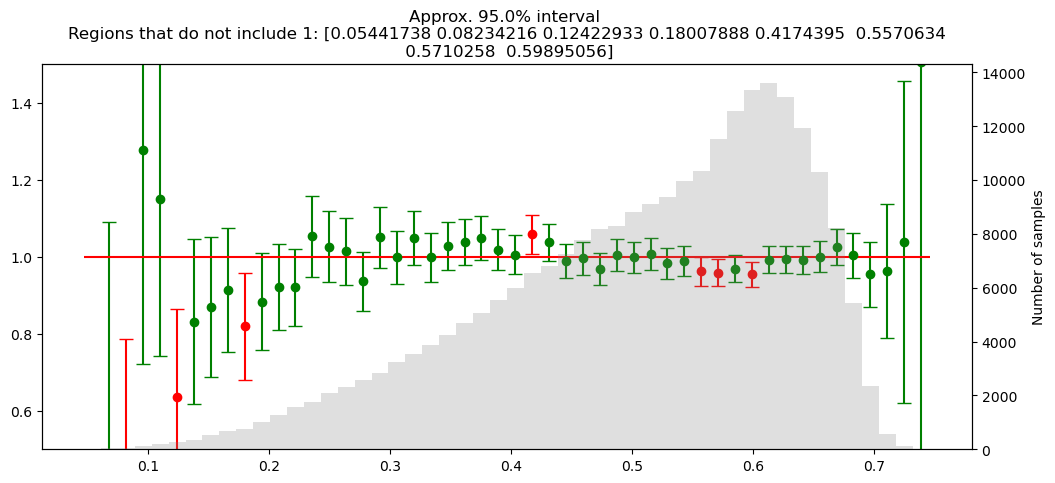

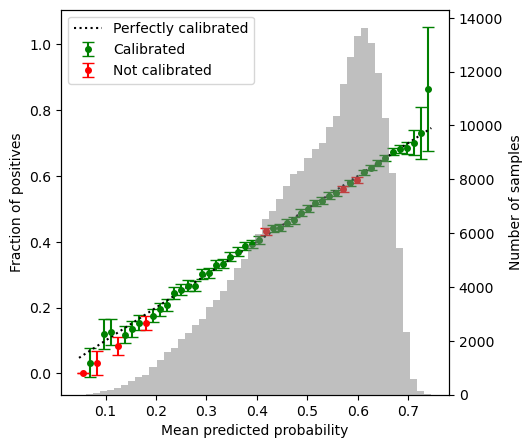

In [20]:
from plots import plot_prob_weighted_histogram1d, calibration_plot

print("**Test Data**")


plot_prob_weighted_histogram1d(events_test.fvt_score, 
                               events_test.fvt_score, 
                               events_test.is_4b,
                               n_bins=50, 
                               sample_weights=events_test.weights,
                               ylim=(0.5, 1.5))
calibration_plot(events_test.fvt_score, events_test.is_4b,
                 bins=50,
                 sample_weights=events_test.weights)

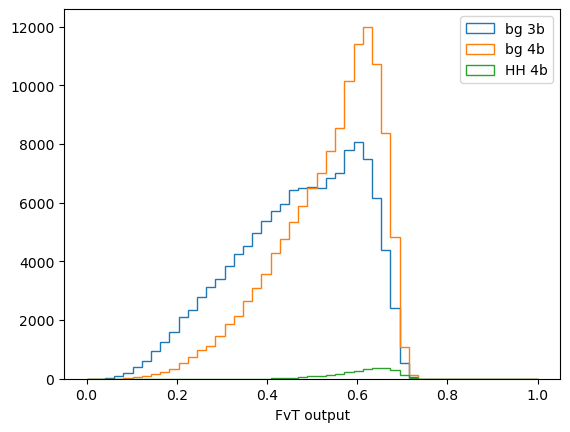

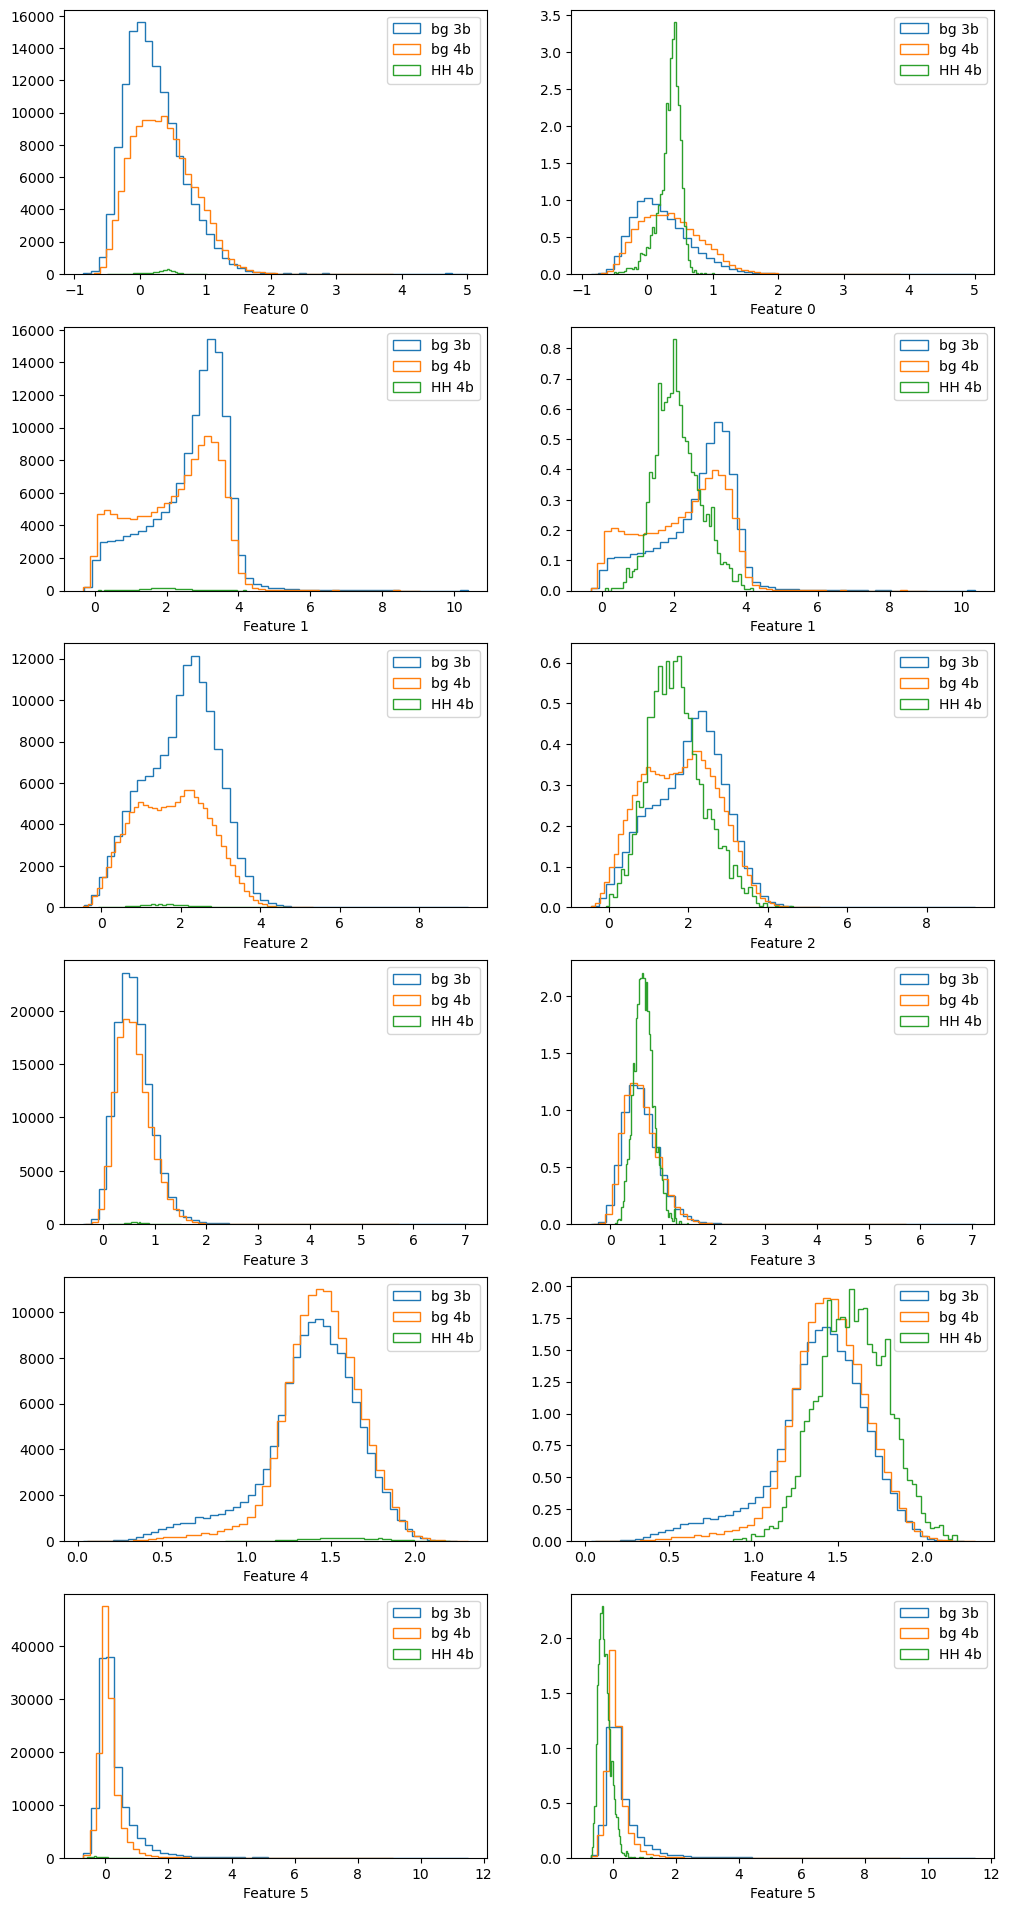

In [21]:
import matplotlib.pyplot as plt

# Pair plots with prob4b threshold

is_3b_test, is_bg4b_test, is_signal_test = events_test.is_3b, events_test.is_bg4b, events_test.is_signal
is_4b_test, w_test = events_test.is_4b, events_test.weights
fvt_score_test = events_test.fvt_score
att_q_repr_test = events_test.att_q_repr

fig, ax = plt.subplots()
bins_range = np.linspace(0, 1, 50)
ax.hist(fvt_score_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
ax.hist(fvt_score_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
ax.hist(fvt_score_test[is_signal_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_signal_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 24))

for i in range(dim_quadjet_features):
    ax[i, 0].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
    ax[i, 0].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
    ax[i, 0].hist(att_q_repr_test[is_signal_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_signal_test])
    ax[i, 0].legend()
    ax[i, 0].set_xlabel(f"Feature {i}")
    
    ax[i, 1].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=True, weights=w_test[is_3b_test])
    ax[i, 1].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=True, weights=w_test[is_bg4b_test])
    ax[i, 1].hist(att_q_repr_test[is_signal_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=True, weights=w_test[is_signal_test])
    ax[i, 1].legend()
    ax[i, 1].set_xlabel(f"Feature {i}")

plt.show()
plt.close()


/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Thresholded 4b clustering
bg4b:  122518
signal:  2514


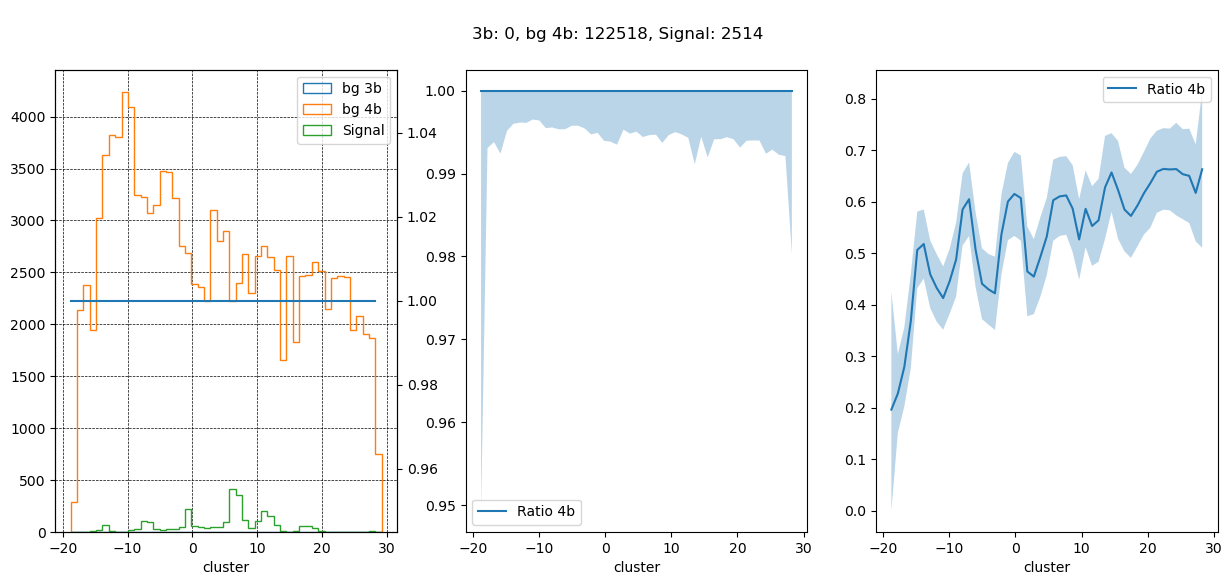

Thresholded samples
3b:  124968
bg4b:  122518
hh4b:  2514


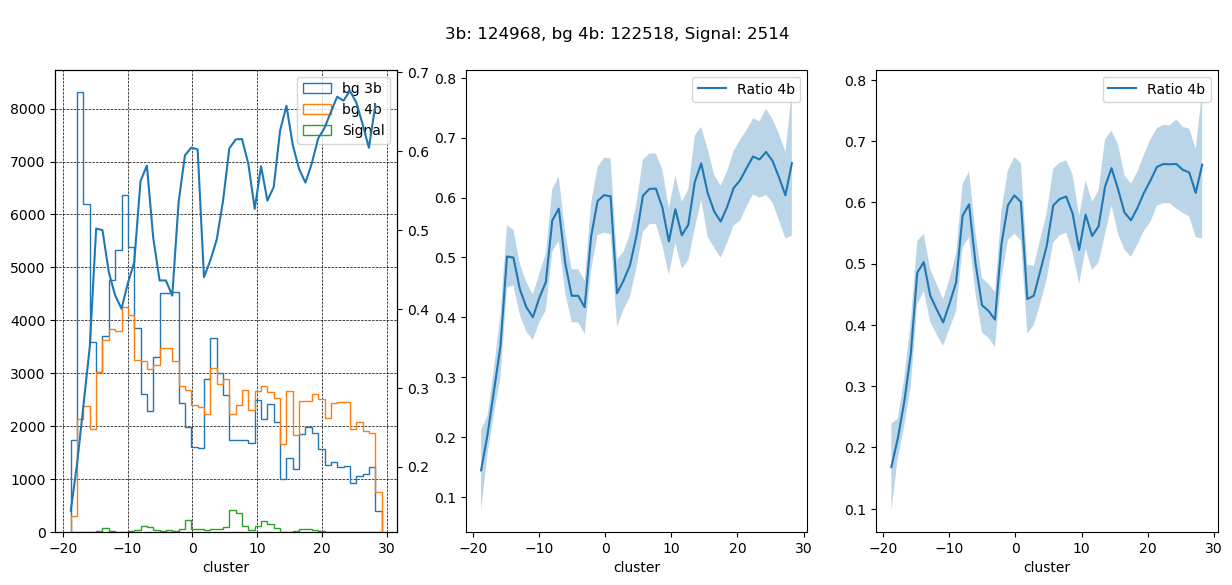

No samples exceeded threshold
All samples
3b:  124968
bg4b:  122518
hh4b:  2514


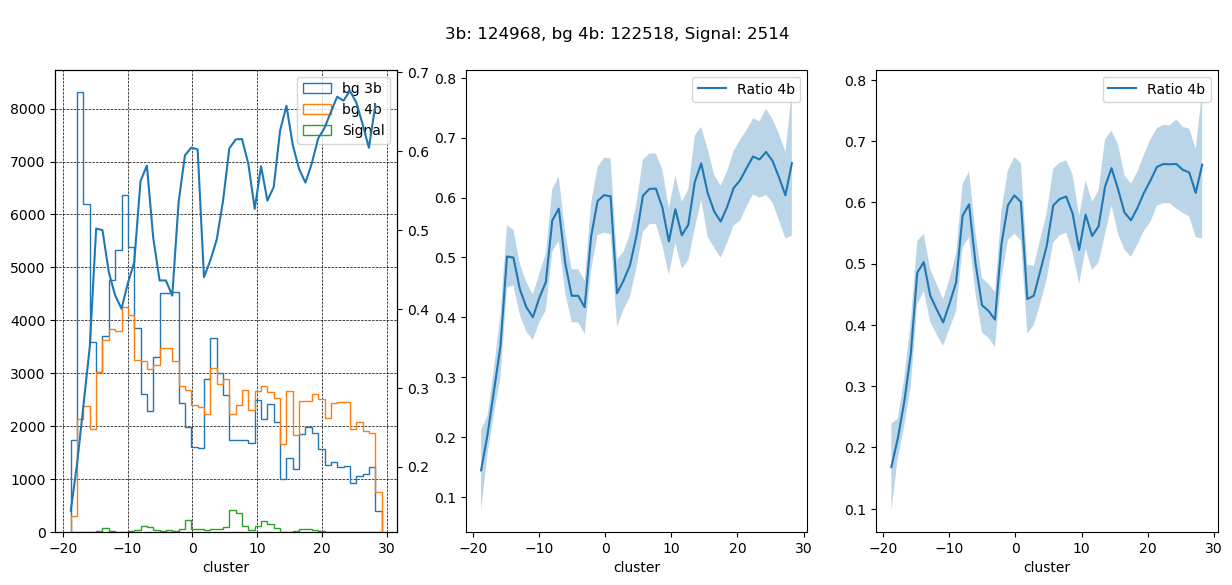

In [22]:
from signal_region import get_fvt_cut_regions
from plots import plot_cluster

fvt_cut = 0.0
w_cuts = np.arange(0.01, 1.01, 0.01)
is_in_regions_list, reducer = get_fvt_cut_regions(events_test, fvt_cut=fvt_cut, w_cuts=w_cuts, seed=seed,
                                                 return_reducer=True, reducer_args={"random_state": seed}, 
                                                 init_bins=10000, max_bins=50)

n_components = 1
fvt_exceeded = events_test.fvt_score > fvt_cut

np.random.seed(seed)
cluster_samples = fvt_exceeded & events_test.is_4b
events_cluster = events_test[cluster_samples]

# print number of points in each class
print("Thresholded 4b clustering")
print("bg4b: ", np.sum(events_cluster.is_bg4b))
print("signal: ", np.sum(events_cluster.is_signal))

cluster_repr_test = events_cluster.npd["cluster_embed"]
plot_cluster(cluster_repr_test, events_cluster, n_components=n_components)


# Thresholded samples

print("Thresholded samples")
print("3b: ", np.sum(is_3b_test & fvt_exceeded))
print("bg4b: ", np.sum(is_bg4b_test & fvt_exceeded))
print("hh4b: ", np.sum(is_signal_test & fvt_exceeded))

thrsed_samples = fvt_exceeded
events_thrsed = events_test[thrsed_samples]
cluster_repr_thrsed = events_thrsed.npd["cluster_embed"]

plot_cluster(cluster_repr_thrsed, events_thrsed, n_components=n_components)

# Failed samples

if not np.any(~fvt_exceeded):
    print("No samples exceeded threshold")
else:
    print("Failed samples")
    print("3b: ", np.sum(is_3b_test & ~fvt_exceeded))
    print("bg4b: ", np.sum(is_bg4b_test & ~fvt_exceeded))
    print("hh4b: ", np.sum(is_signal_test & ~fvt_exceeded))

    failed_samples = ~fvt_exceeded
    events_failed = events_test[failed_samples]
    cluster_repr_failed = events_failed.npd["cluster_embed"]

    plot_cluster(cluster_repr_failed, events_failed, n_components=n_components)

# all samples

print("All samples")
print("3b: ", np.sum(is_3b_test))
print("bg4b: ", np.sum(is_bg4b_test))
print("hh4b: ", np.sum(is_signal_test))

all_samples = np.ones(len(events_test), dtype=bool)
events_all = events_test[all_samples]
cluster_repr_all = events_all.npd["cluster_embed"]

plot_cluster(cluster_repr_all, events_all, n_components=n_components)

In [23]:
# save reducers

from signal_region import get_fvt_cut_regions, get_regions
import pickle

w_cuts = np.arange(0.01, 1.01, 0.01)
cluster_embeds_dict = {}
is_in_regions_list_dict = {"simple": {}, "fvt": {}}
for p4b_method in ["simple", "fvt"]:
    for fvt_cut in np.arange(0.0, 0.8, 0.1):
        reducer_name = f"data/reducers/reducer_{run_name}_{fvt_cut}.pkl"
        embed_name = f"data/embeddings/embed_{run_name}_{fvt_cut}.npy"

        if pathlib.Path(reducer_name).exists():
            print(f"Reducer {reducer_name} exists, loading...")
            reducer = pickle.load(open(reducer_name, "rb"))
            fvt_exceeded = events_test.fvt_score > fvt_cut

            if pathlib.Path(embed_name).exists():
                print(f"Embedding {embed_name} exists, loading...")
                events_test.npd["cluster_embed"] = np.load(embed_name)
                reuse_embed = True
            else:
                reuse_embed = False

            is_in_regions_list = get_regions(events_test, reducer, fvt_exceeded, w_cuts, init_bins=10000, 
                                            max_bins=50, seed=seed, reuse_embed=reuse_embed, p4b_method=p4b_method)
        
        
        else:
            is_in_regions_list, reducer = get_fvt_cut_regions(events_test, fvt_cut=fvt_cut, w_cuts=w_cuts, seed=seed,
                                                        return_reducer=True, reducer_args={"random_state": seed}, 
                                                        init_bins=10000, max_bins=50, p4b_method=p4b_method)
        
            # save reducer as a pickle file
            with open(reducer_name, "wb") as f:
                pickle.dump(reducer, f)

        if not pathlib.Path(embed_name).exists():
            # save embedding as a numpy file
            np.save(embed_name, events_test.npd["cluster_embed"])

        cluster_embeds_dict[fvt_cut] = events_test.npd["cluster_embed"].reshape(-1).copy()
        is_in_regions_list_dict[p4b_method][fvt_cut] = is_in_regions_list.copy()

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/soheuny/miniconda3/envs/coffe

Reducer data/reducers/reducer_fvt_picoAOD_signal_ratio=0.02_four_tag_ratio=0.5_dijet=6_quadjet=6_n_3b=250000_n_all4b=250000_epochs=50_batch_size=1024_val_ratio=0.33_test_ratio=0.5_seed=92_0.0.pkl exists, loading...
Embedding data/embeddings/embed_fvt_picoAOD_signal_ratio=0.02_four_tag_ratio=0.5_dijet=6_quadjet=6_n_3b=250000_n_all4b=250000_epochs=50_batch_size=1024_val_ratio=0.33_test_ratio=0.5_seed=92_0.0.npy exists, loading...
Reducer data/reducers/reducer_fvt_picoAOD_signal_ratio=0.02_four_tag_ratio=0.5_dijet=6_quadjet=6_n_3b=250000_n_all4b=250000_epochs=50_batch_size=1024_val_ratio=0.33_test_ratio=0.5_seed=92_0.1.pkl exists, loading...
Embedding data/embeddings/embed_fvt_picoAOD_signal_ratio=0.02_four_tag_ratio=0.5_dijet=6_quadjet=6_n_3b=250000_n_all4b=250000_epochs=50_batch_size=1024_val_ratio=0.33_test_ratio=0.5_seed=92_0.1.npy exists, loading...
Reducer data/reducers/reducer_fvt_picoAOD_signal_ratio=0.02_four_tag_ratio=0.5_dijet=6_quadjet=6_n_3b=250000_n_all4b=250000_epochs=50_ba

In [27]:
# use viridis color map for different FvT cuts
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3, subplot_titles=("Simple counting", "FvT score", "Simple vs FvT"))

colorscale = px.colors.sequential.Viridis
fvt_cut_values = np.array(list(cluster_embeds_dict.keys()))

w_in_regions_dict = {"simple": [], "fvt": []}
signal_w_in_regions_dict = {"simple": [], "fvt": []}

for fvt_cut in cluster_embeds_dict.keys():
    norm_fvt_cut = (fvt_cut - fvt_cut_values.min()) / (fvt_cut_values.max() - fvt_cut_values.min())
    color = colorscale[int(norm_fvt_cut * (len(colorscale) - 1))]

    for ax_cnt, p4b_method in enumerate(["simple", "fvt"]):
        is_in_regions_list = is_in_regions_list_dict[p4b_method][fvt_cut]
        w_in_regions_dict[p4b_method] = []
        signal_w_in_regions_dict[p4b_method] = []
        
        for i, w_cut in enumerate(np.arange(0.01, 1, 0.01)):
            is_in_region = is_in_regions_list[i]
            w_in_regions_dict[p4b_method].append(np.sum(events_test.weights[is_in_region]) / events_test.total_weight)
            signal_w_in_regions_dict[p4b_method].append(np.sum(events_test.weights[is_in_region & is_signal_test]) / events_test.total_weight_signal)

        fig.add_trace(go.Scatter(
            x=np.arange(0.01, 1, 0.01), 
            y=signal_w_in_regions_dict[p4b_method],
            mode="lines", 
            legendgroup=f"FvT cut: {fvt_cut:.2f}",
            name=f"FvT cut: {fvt_cut:.2f}",
            showlegend=False,
            line=dict(color=color)
        ), row=1, col=ax_cnt + 1)


    fig.add_trace(go.Scatter(
        x=signal_w_in_regions_dict["simple"],
        y=signal_w_in_regions_dict["fvt"],
        mode="lines",
        legendgroup=f"FvT cut: {fvt_cut:.2f}",
        name=f"FvT cut: {fvt_cut:.2f}",
        showlegend=True,
        line=dict(color=color)
    ), row=1, col=3)

for col_idx in range(1, 3):
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode="lines", name="y=x", line=dict(dash="dash")), row=1, col=col_idx)
    fig.update_xaxes(title_text="% all samples", row=1, col=col_idx)
    fig.update_yaxes(title_text="% signal samples", row=1, col=col_idx)

fig.update_xaxes(title_text="Simple counting", row=1, col=3)
fig.update_yaxes(title_text="FvT score", row=1, col=3)

fig.show()

In [28]:
fig = make_subplots(rows=1, cols=2, shared_xaxes=True, subplot_titles=("Simple counting", "FvT score"))

colorscale = px.colors.sequential.Viridis
fvt_cut_values = np.array(list(cluster_embeds_dict.keys()))
n_bins = 50

for fvt_cut in cluster_embeds_dict.keys():
    norm_fvt_cut = (fvt_cut - fvt_cut_values.min()) / (fvt_cut_values.max() - fvt_cut_values.min())
    color = colorscale[int(norm_fvt_cut * (len(colorscale) - 1))]

    cluster_embed_test = cluster_embeds_dict[fvt_cut]
    bins_range = np.linspace(np.min(cluster_embed_test), 
                            np.max(cluster_embed_test), n_bins + 1)

    hist_3b, _ = np.histogram(cluster_embed_test[is_3b_test], 
                            bins=bins_range, weights=w_test[is_3b_test])
    hist_bg4b, _ = np.histogram(cluster_embed_test[is_bg4b_test], 
                                bins=bins_range, weights=w_test[is_bg4b_test])
    hist_signal, _ = np.histogram(cluster_embed_test[is_signal_test], 
                                bins=bins_range, weights=w_test[is_signal_test])
    hist_all = hist_3b + hist_bg4b + hist_signal
    hist_4b = hist_bg4b + hist_signal

    ratio_4b_cnt = hist_4b / hist_all
    ratio_4b_fvt = np.zeros_like(ratio_4b_cnt)
    for i in range(len(ratio_4b_fvt)):
        weights_bin = np.sum(
            w_test[(cluster_embed_test > bins_range[i]) 
                & (cluster_embed_test < bins_range[i + 1])])
        fvt_score_sum = np.sum(
            events_test.fvt_score[(cluster_embed_test > bins_range[i]) 
                                & (cluster_embed_test < bins_range[i + 1])])
        ratio_4b_fvt[i] = fvt_score_sum / weights_bin

    # sort by ratio_4b_cnt and plot hist_3b, hist_bg4b, hist_signal

    sort_idx_cnt = np.argsort(ratio_4b_cnt)[::-1]
    fig.add_trace(
        go.Scatter(x=np.cumsum(hist_all[sort_idx_cnt]) / np.sum(hist_all),
                    y=np.cumsum(hist_signal[sort_idx_cnt]) / np.sum(hist_signal),
                    mode="lines",
                    line_shape="hv",
                    legendgroup=f"FvT cut: {fvt_cut:.2f}",
                    name=f"FvT cut: {fvt_cut:.2f}",
                    showlegend=False,
                    line=dict(color=color)), 
                    row=1, col=1)
    
    sort_idx_fvt = np.argsort(ratio_4b_fvt)[::-1]
    fig.add_trace(
        go.Scatter(x=np.cumsum(hist_all[sort_idx_fvt]) / np.sum(hist_all),
                    y=np.cumsum(hist_signal[sort_idx_fvt]) / np.sum(hist_signal),
                    mode="lines",
                    line_shape="hv",
                    legendgroup=f"FvT cut: {fvt_cut:.2f}",
                    name=f"FvT cut: {fvt_cut:.2f}",
                    showlegend=True,
                    line=dict(color=color)), 
                    row=1, col=2)


    # fig.add_trace(
    #     go.Scatter(x=np.cumsum(hist_signal[sort_idx_cnt]) / np.sum(hist_signal), 
    #                 y=np.cumsum(hist_signal[sort_idx_fvt]) / np.sum(hist_signal),
    #                 mode="lines",
    #                 legendgroup=f"FvT cut: {fvt_cut:.2f}",
    #                 name=f"FvT cut: {fvt_cut:.2f}",
    #                 showlegend=True,
    #                 line=dict(color=color)), row=1, col=3)

fig.update_xaxes(title_text="% all samples", row=1, col=1)
fig.update_yaxes(title_text="% signal samples", row=1, col=1)

fig.update_xaxes(title_text="% all samples", row=1, col=2)
fig.update_yaxes(title_text="% signal samples", row=1, col=2)

# fig.update_xaxes(title_text="Simple counting", row=1, col=3)
# fig.update_yaxes(title_text="FvT score", row=1, col=3)    
# fig.add_trace(
#     go.Scatter(
#     x=[0, 1], y=[0, 1], mode="lines", line=dict(dash="dash"), 
#     name="y=x", showlegend=True
#     ), row=1, col=3)
    

fig.show()

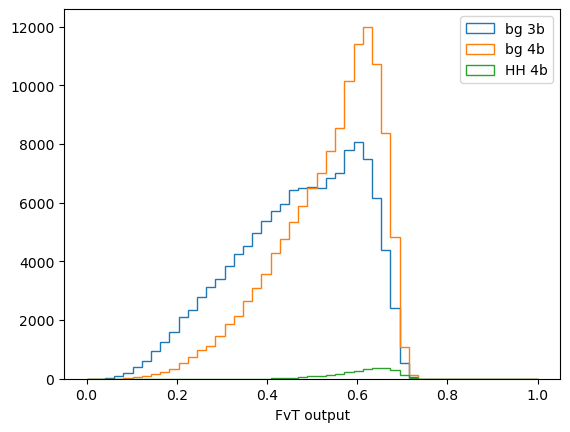

In [29]:
fig, ax = plt.subplots()
bins_range = np.linspace(0, 1, 50)
ax.hist(fvt_score_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
ax.hist(fvt_score_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
ax.hist(fvt_score_test[is_signal_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_signal_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()

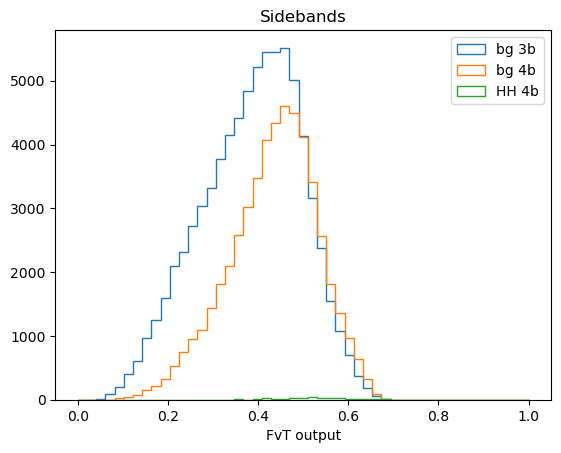

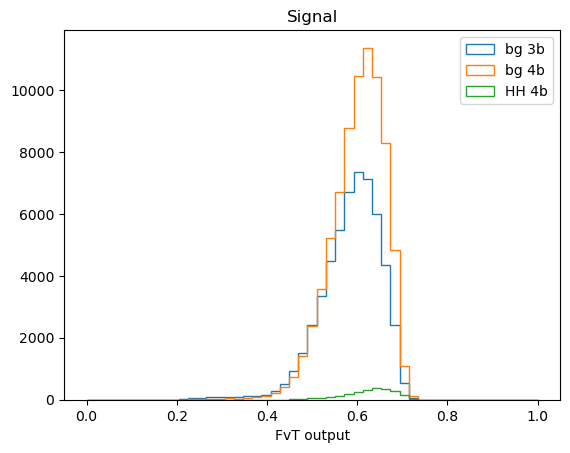

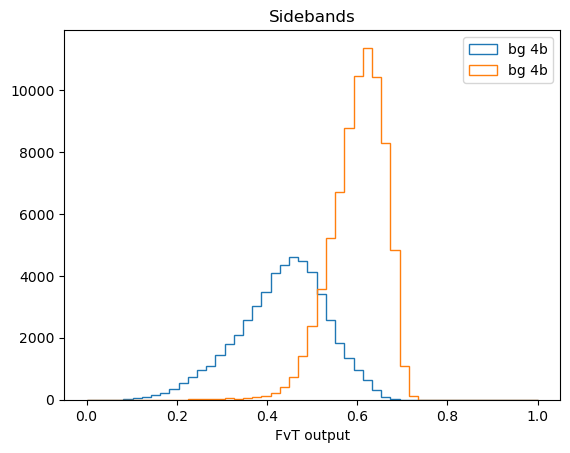

In [30]:
w_cut = 0.5
fvt_cut = 0.0
is_in_signal_region = is_in_regions_list_dict["simple"][fvt_cut][int(w_cut * 100)]

fig, ax = plt.subplots()
bins_range = np.linspace(0, 1, 50)
plt.title("Sidebands")
ax.hist(fvt_score_test[is_3b_test & ~is_in_signal_region], 
        bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, 
        weights=w_test[is_3b_test & ~is_in_signal_region])
ax.hist(fvt_score_test[is_bg4b_test & ~is_in_signal_region], 
        bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, 
        weights=w_test[is_bg4b_test & ~is_in_signal_region])
ax.hist(fvt_score_test[is_signal_test & ~is_in_signal_region], 
        bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, 
        weights=w_test[is_signal_test & ~is_in_signal_region])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()

fig, ax = plt.subplots()
bins_range = np.linspace(0, 1, 50)
plt.title("Signal")
ax.hist(fvt_score_test[is_3b_test & is_in_signal_region], 
        bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, 
        weights=w_test[is_3b_test & is_in_signal_region])
ax.hist(fvt_score_test[is_bg4b_test & is_in_signal_region], 
        bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, 
        weights=w_test[is_bg4b_test & is_in_signal_region])
ax.hist(fvt_score_test[is_signal_test & is_in_signal_region], 
        bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, 
        weights=w_test[is_signal_test & is_in_signal_region])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

fig, ax = plt.subplots()
bins_range = np.linspace(0, 1, 50)
plt.title("Sidebands")
ax.hist(fvt_score_test[is_bg4b_test & ~is_in_signal_region], 
        bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, 
        weights=w_test[is_bg4b_test & ~is_in_signal_region])
ax.hist(fvt_score_test[is_bg4b_test & is_in_signal_region], 
        bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, 
        weights=w_test[is_bg4b_test & is_in_signal_region])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()
plt.close()

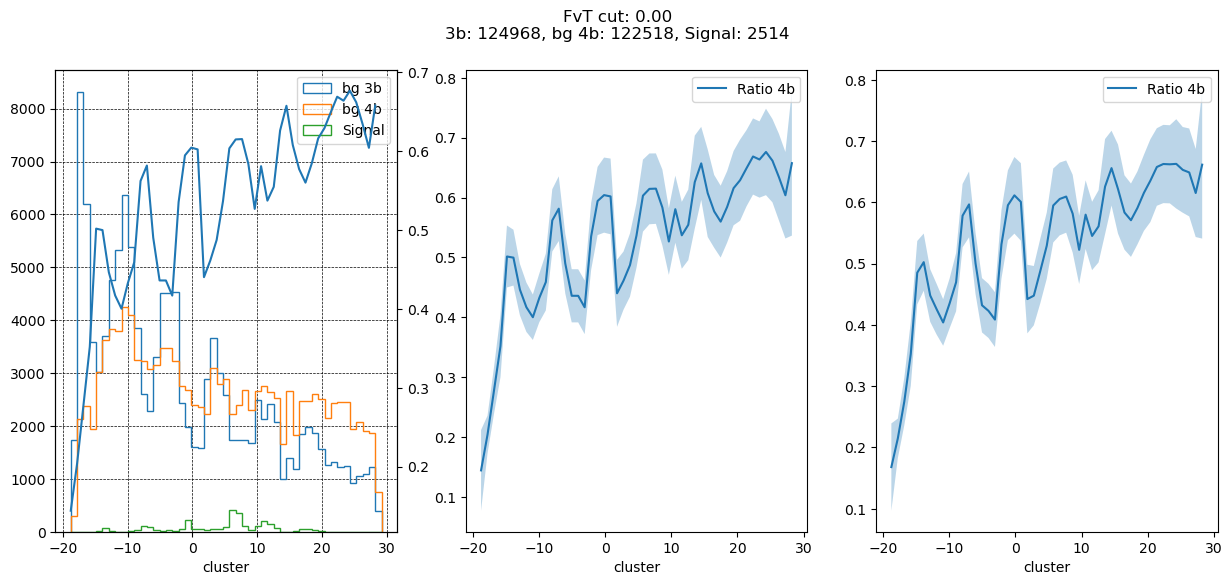

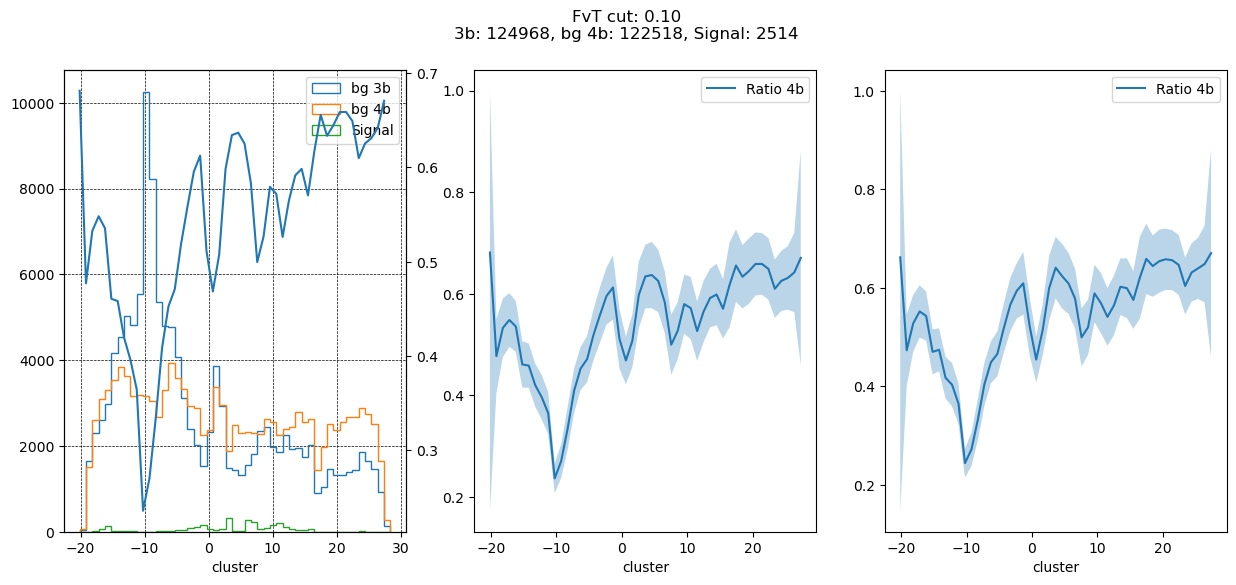

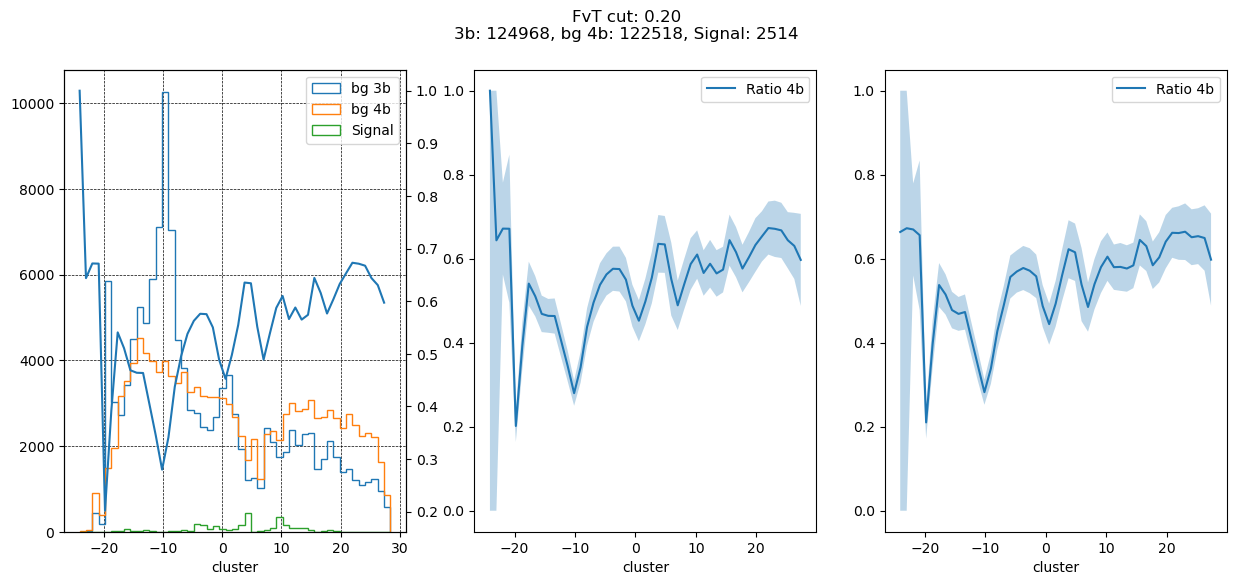

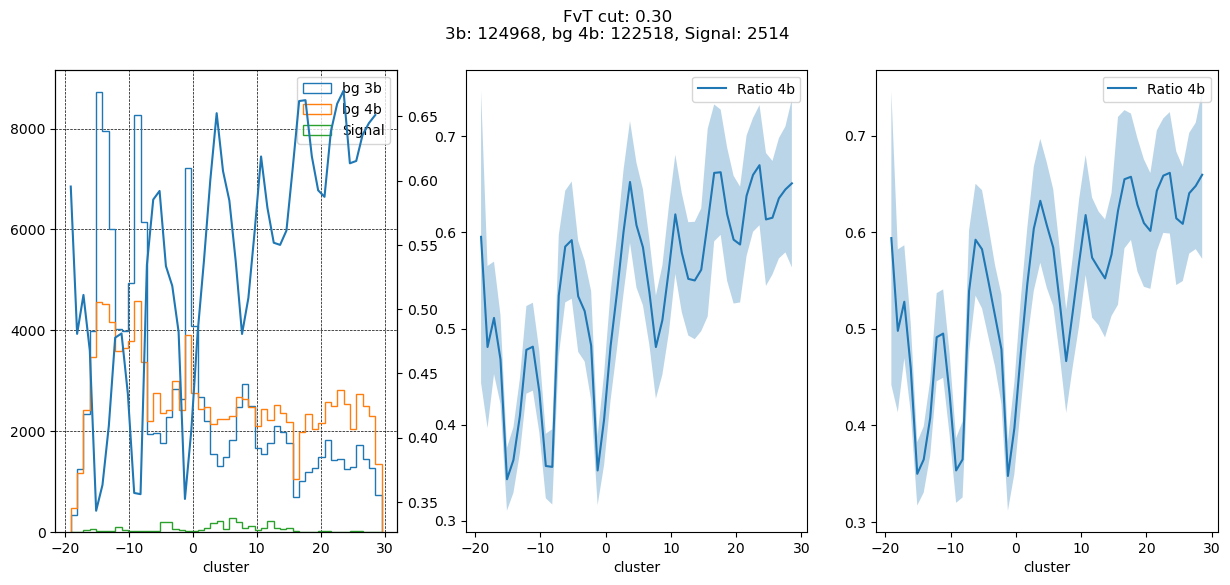

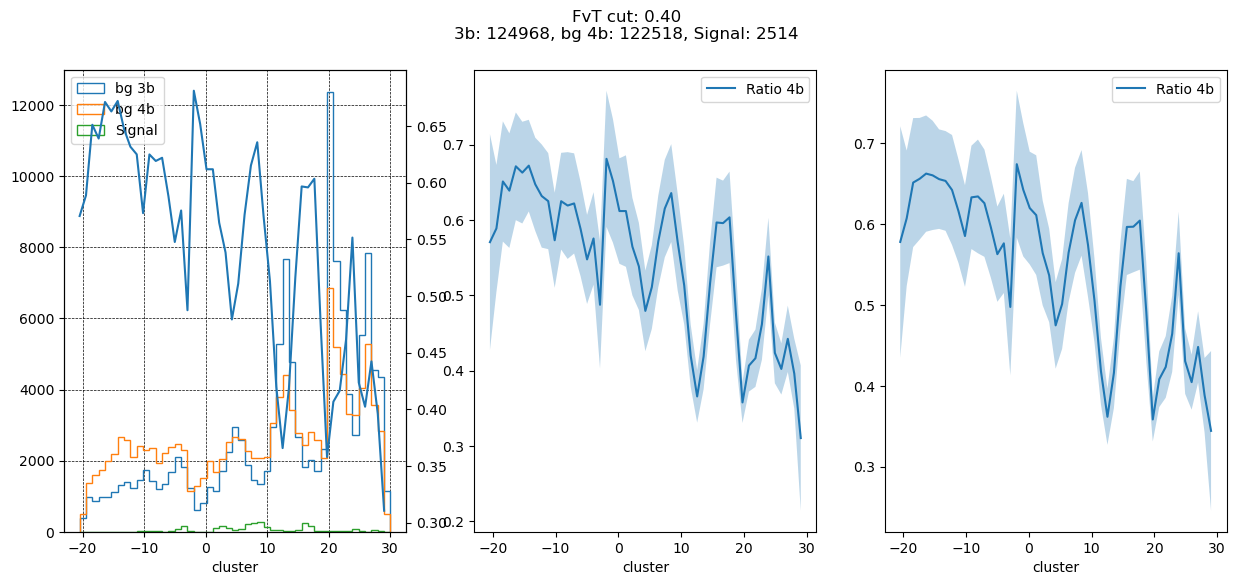

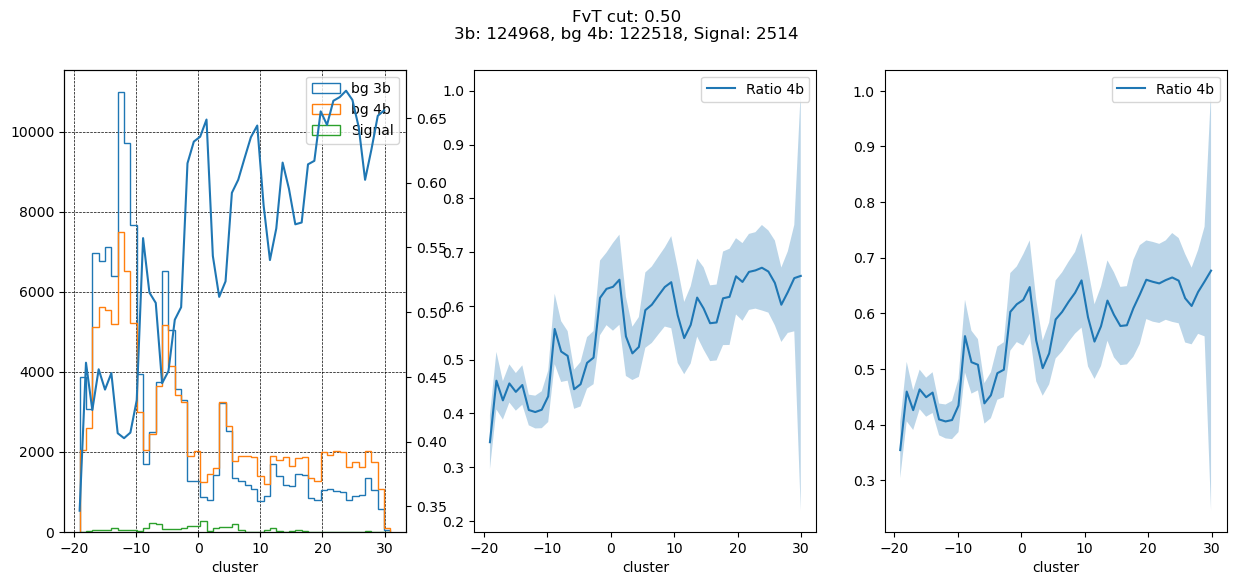

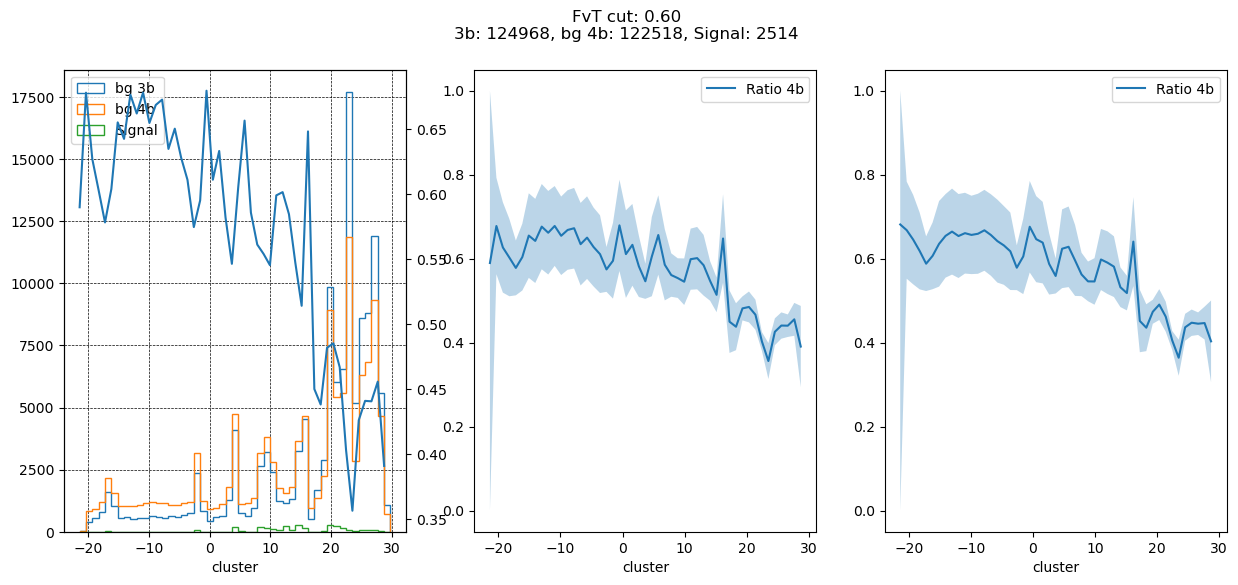

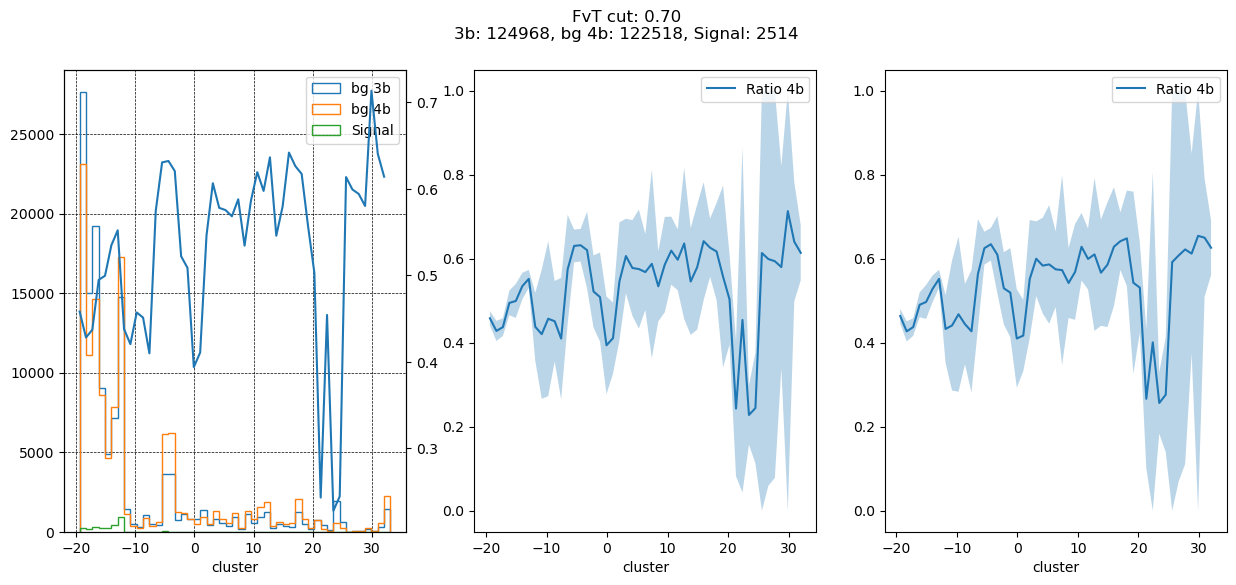

In [31]:
for fvt_cut in cluster_embeds_dict.keys():
    plot_cluster(cluster_embeds_dict[fvt_cut].reshape(-1, 1), events_test, 
                 n_components=n_components, title=f"FvT cut: {fvt_cut:.2f}")

In [21]:
fvt_cut = 0.2
reducer_name = f"data/reducers/reducer_{run_name}_{fvt_cut}.pkl"
embed_name = f"data/embeddings/embed_{run_name}_{fvt_cut}.npy"

events_test.npd["cluster_embed"] = np.load(embed_name)
reducer = pickle.load(open(reducer_name, "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'data/embeddings/embed_fvt_picoAOD_signal_ratio=0.01_dijet=6_quadjet=6_n_3b=250000_n_all4b=250000_epochs=50_seed=42_0.2.npy'

/tmp/ipykernel_1526915/244554778.py:24: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1526915/244554778.py:29: RuntimeWarning:

invalid value encountered in divide



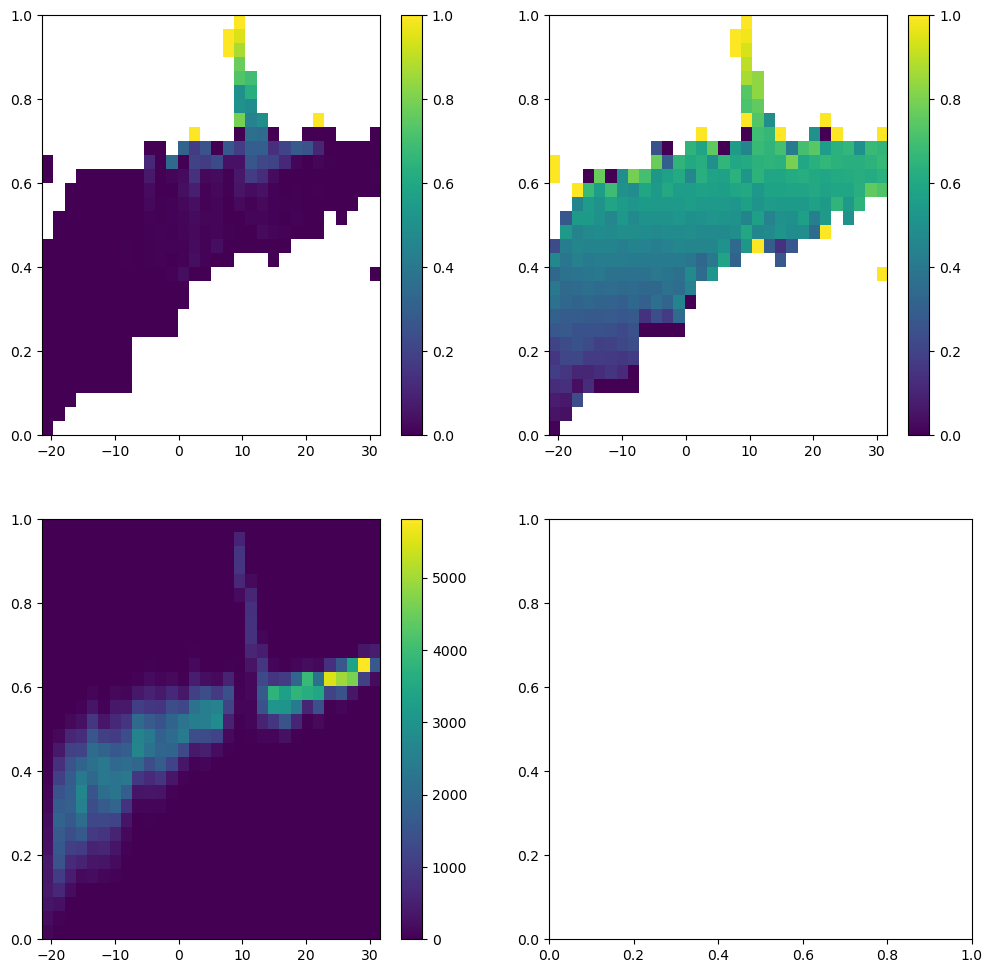

In [55]:
# 2d histogram of cluster embedding and FvT score

n_bins = 30
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
xedges = np.linspace(np.min(events_test.npd["cluster_embed"][:, 0]), np.max(events_test.npd["cluster_embed"][:, 0]), n_bins + 1)
yedges = np.linspace(0, 1, n_bins + 1)

hist_3b, _, _ = np.histogram2d(events_test.npd["cluster_embed"][is_3b_test, 0],
                            events_test.fvt_score[is_3b_test], bins=(xedges, yedges), weights=w_test[is_3b_test])
hist_bg4b, _, _ = np.histogram2d(events_test.npd["cluster_embed"][is_bg4b_test, 0],
                                events_test.fvt_score[is_bg4b_test], bins=(xedges, yedges), weights=w_test[is_bg4b_test])
hist_signal, _, _ = np.histogram2d(events_test.npd["cluster_embed"][is_signal_test, 0],
                                events_test.fvt_score[is_signal_test], bins=(xedges, yedges), weights=w_test[is_signal_test])

# plot each 2d histogram using hist_3b, hist_bg4b, hist_signal

hist_all = hist_3b + hist_bg4b + hist_signal
hist_4b = hist_bg4b + hist_signal

# ax.imshow(hist_3b.T / hist_all.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto", cmap="viridis", alpha=0.5)
# ax.imshow(hist_bg4b.T / hist_all.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto", cmap="viridis", alpha=0.5)

current_ax = ax[0, 0]
im = ax[0, 0].imshow(hist_signal.T / hist_all.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
          aspect="auto", cmap="viridis", alpha=1)
fig.colorbar(im, ax=current_ax)

current_ax = ax[0, 1]
im = ax[0, 1].imshow(hist_4b.T / hist_all.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
          aspect="auto", cmap="viridis", alpha=1)
fig.colorbar(im, ax=current_ax)

current_ax = ax[1, 0]
im = current_ax.imshow(hist_all.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
          aspect="auto", cmap="viridis", alpha=1)
fig.colorbar(im, ax=current_ax)

plt.show()
plt.close()



# Randomness of UMAP transformation

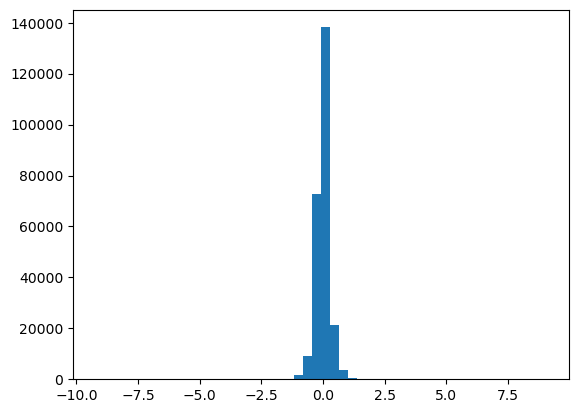

In [26]:
cluster_embed_all = reducer.transform(events_test.att_q_repr)
cluster_embed_almost = reducer.transform(events_test.att_q_repr[:-1])

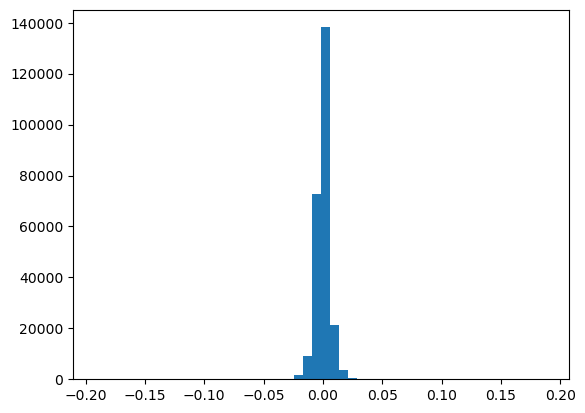

In [27]:
plt.hist((cluster_embed_almost - cluster_embed_all[:-1]) / (cluster_embed_all.max() - cluster_embed_all.min()), bins=50)
plt.show()
plt.close()

In [15]:
# fast umap transformation via parallel processing

from umap import UMAP
import multiprocessing as mp

def fast_umap(reducer: UMAP, n_workers: int = 4):
    def fast_umap_inner(data: np.ndarray):
        with mp.Pool(n_workers) as pool:
            return np.vstack(pool.map(reducer.transform, np.array_split(data, n_workers)))
        
    return fast_umap_inner

In [31]:
fast_reducer = fast_umap(reducer, n_workers=4)

a1 = fast_reducer(events_test.att_q_repr)
a2 = reducer.transform(events_test.att_q_repr)

print(np.allclose(a1, a2))

False


In [40]:
print(reducer.transform(events_test.att_q_repr[:1000])[:5])
print(reducer.transform(events_test.att_q_repr[:1000])[:5])
print(reducer.transform(events_test.att_q_repr[:1000])[:5])
print(reducer.transform(events_test.att_q_repr[:1001])[:5])
print(reducer.transform(events_test.att_q_repr[:1002])[:5])

[[  0.29027387]
 [-13.050937  ]
 [  1.372062  ]
 [ 29.800888  ]
 [ -8.503721  ]]
[[  0.29027387]
 [-13.050937  ]
 [  1.372062  ]
 [ 29.800888  ]
 [ -8.503721  ]]
[[  0.29027387]
 [-13.050937  ]
 [  1.372062  ]
 [ 29.800888  ]
 [ -8.503721  ]]
[[  0.22824572]
 [-13.106337  ]
 [  1.3638166 ]
 [ 29.815956  ]
 [ -8.604633  ]]
[[  0.26417902]
 [-13.236632  ]
 [  1.4917599 ]
 [ 29.78286   ]
 [ -8.686122  ]]


In [35]:
fast_reducer(events_test.att_q_repr)

array([[  0.22914849],
       [-13.029396  ],
       [  1.2767615 ],
       ...,
       [ 16.324974  ],
       [ 12.842677  ],
       [ -9.771144  ]], dtype=float32)

In [37]:
np.max(np.abs(a1 - a2))

12.577739

In [69]:
assert np.all(~is_in_sr | is_in_cr)

events_sr = events_test[is_in_sr]
events_cr = events_test[~is_in_sr & is_in_cr]

w_cr, is_3b_cr, is_bg4b_cr, is_signal_cr = events_cr.weights, events_cr.is_3b, events_cr.is_bg4b, events_cr.is_signal
w_sr, is_3b_sr, is_bg4b_sr, is_signal_sr = events_sr.weights, events_sr.is_3b, events_sr.is_bg4b, events_sr.is_signal

X_cr_torch = events_cr.X_torch
X_sr_torch = events_sr.X_torch

# print weights of 3b, bg4b, signal

print("Sideband")
print("3b: ", np.sum(w_cr[is_3b_cr]))
print("bg4b: ", np.sum(w_cr[is_bg4b_cr]))
print("signal: ", np.sum(w_cr[is_signal_cr]))
print("")

print("Signal Region")
print("3b: ", np.sum(w_sr[is_3b_sr]))
print("bg4b: ", np.sum(w_sr[is_bg4b_sr]))
print("signal: ", np.sum(w_sr[is_signal_sr]))
print("")

print("Portion of Signal in Signal Region")
print("signal: ", np.sum(w_sr[is_signal_sr]) / np.sum(w_test[is_signal_test]))
print("")
print("SR / (SR + SB)")
print(np.sum(w_sr) / (np.sum(w_sr) + np.sum(w_cr)))

from ancillary_features import get_m4j

m4j_cr = get_m4j(X_cr_torch)
m4j_sr = get_m4j(X_sr_torch)

# plot histograms of m4j
bins_range = np.linspace(min(np.min(m4j_cr), np.min(m4j_sr)), max(np.max(m4j_cr), np.max(m4j_sr)), 50)

plt.hist(m4j_cr, bins=bins_range, weights=w_cr, histtype="step", label="Sideband region")
plt.hist(m4j_sr, bins=bins_range, weights=w_sr, histtype="step", label="Signal region")
plt.xlabel("m4j")
plt.ylabel("Counts")
plt.legend()
plt.show()
plt.close()



NameError: name 'is_in_sr' is not defined

In [12]:
discard_failed = False

sr_cr_run_name = "_".join(
    [
        run_name,
        "sb",
        f"w_cut_sr={w_cut_sr}",
        f"w_cut_cr={w_cut_cr}",
        f"fvt_cut={fvt_cut}",
    ]
    + (["discard_failed"]
    if discard_failed
    else [])
)

print("run name: ", sr_cr_run_name)

train_sb = False


events_cr_train, events_cr_val = events_cr.split(train_val_ratio, name_1="cr_train", name_2="cr_val", seed=seed_)
events_cr_train.fit_batch_size(batch_size)
events_cr_val.fit_batch_size(batch_size)

sr_cr_train_dataset = events_cr_train.to_tensor_dataset()
sr_cr_val_dataset = events_cr_val.to_tensor_dataset()


# Train SB FvT 

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 20
lr = 1e-3

if train_sb:
    pl.seed_everything(42)


    sb_model = FvTClassifier(num_classes, 
                        dim_input_jet_features, 
                        dim_dijet_features, 
                        dim_quadjet_features, 
                        run_name=sr_cr_run_name,
                        device=torch.device("cuda:0"),
                        lr=lr)

    sb_model.fit(sr_cr_train_dataset, sr_cr_val_dataset, batch_size=1024, max_epochs=max_epochs)

run name:  fvt_picoAOD_signal_ratio=0.05_dijet=6_quadjet=6_n_3b=250000_n_all4b=250000_epochs=50_seed=42_sb_w_cut_sr=0.1_w_cut_cr=1.0_fvt_cut=0.0


In [13]:
from plots import plot_prob_weighted_histogram1d, calibration_plot

sr_cr_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{sr_cr_run_name}_best.ckpt")
sr_cr_model.eval()
q_repr_sr_cr_val = get_fvt_reprs(events_cr_val.X_torch, sr_cr_model)[0]
q_repr_sr_cr_val = np.concatenate(q_repr_sr_cr_val, axis=0)
fvt_score_sr_cr_val = sr_cr_model.predict(events_cr_val.X_torch)[:, 1].cpu().numpy()


plot_prob_weighted_histogram1d(fvt_score_sr_cr_val, 
                               fvt_score_sr_cr_val, 
                                 events_cr_val.is_4b,
                               n_bins=50, 
                               sample_weights=events_cr_val.weights,
                               ylim=(0.5, 1.5))

FileNotFoundError: [Errno 2] No such file or directory: '/home/soheuny/HH4bsim/playground/checkpoints/fvt_picoAOD_signal_ratio=0.05_dijet=6_quadjet=6_n_3b=250000_n_all4b=250000_epochs=50_seed=42_sb_w_cut_sr=0.1_w_cut_cr=1.0_fvt_cut=0.0_best.ckpt'

In [ ]:
fvt_score_new = sr_cr_model.predict(events_sr.X_torch)[:, 1].cpu().numpy()
fvt_score_orig = fvt_model.predict(events_sr.X_torch)[:, 1].cpu().numpy()

In [ ]:
w_cr, is_3b_cr, is_bg4b_cr, is_signal_cr, is_4b_cr = events_cr.weights, events_cr.is_3b, events_cr.is_bg4b, events_cr.is_signal, events_cr.is_4b
w_sr, is_3b_sr, is_bg4b_sr, is_signal_sr, is_4b_sr = events_sr.weights, events_sr.is_3b, events_sr.is_bg4b, events_sr.is_signal, events_sr.is_4b
fvt_exceeded_test = events_test.fvt_score > fvt_cut

def plot_reweighting(hist_x_test, name, geom):

    hist_x_sr = hist_x_test[is_in_sr]
    hist_x_cr = hist_x_test[~is_in_sr & is_in_cr]

    # reweight 3b samples by fvt_score_new / (1 - fvt_score_new)

    total_3b_cr = np.sum(w_cr[is_3b_cr])
    total_4b_cr = np.sum(w_cr[is_4b_cr])

    total_3b_sr = np.sum(w_sr[is_3b_sr])
    total_4b_sr = np.sum(w_sr[is_4b_sr])

    total_3b_fvt = np.sum(w_test[is_3b_test])
    total_4b_fvt = np.sum(w_test[is_4b_test])

    sb_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_cr / total_3b_cr)
    fvt_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_fvt / total_3b_fvt)

    reweights_new_sr = w_sr * np.where(
        is_3b_sr, sb_reweight_const * (fvt_score_new / (1 - fvt_score_new)), 1
    )
    reweights_orig_sr = w_sr * np.where(
        is_3b_sr, fvt_reweight_const * (fvt_score_orig / (1 - fvt_score_orig)), 1
    )

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    # bins to be a geometric sequence

    if geom:
        bins_range = np.geomspace(hist_x_test.min(), hist_x_test.max(), 20)
    else:
        bins_range = np.linspace(hist_x_test.min(), hist_x_test.max(), 20)

    hist_3b, _ = np.histogram(
        hist_x_sr[is_3b_sr], bins=bins_range, weights=w_sr[is_3b_sr]
    )
    hist_rwsb3b, _ = np.histogram(
        hist_x_sr[is_3b_sr], bins=bins_range, weights=reweights_new_sr[is_3b_sr]
    )
    hist_rwfvt3b, _ = np.histogram(
        hist_x_sr[is_3b_sr], bins=bins_range, weights=reweights_orig_sr[is_3b_sr]
    )
    hist_bg4b, _ = np.histogram(
        hist_x_sr[is_bg4b_sr], bins=bins_range, weights=w_sr[is_bg4b_sr]
    )

    # normalize the histograms
    scale_3b = np.sum(hist_bg4b) / np.sum(hist_3b)
    scale_rwsb3b = np.sum(hist_bg4b) / np.sum(hist_rwsb3b)
    scale_rwfvt3b = np.sum(hist_bg4b) / np.sum(hist_rwfvt3b)

    # scale_3b = 1
    # scale_rwsb3b = 1
    # scale_rwfvt3b = 1

    err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
    err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
    err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b

    ax[0].stairs(hist_3b, bins_range, label="3b")
    ax[0].stairs(hist_rwsb3b, bins_range, label="SB reweighted 3b")
    ax[0].stairs(hist_rwfvt3b, bins_range, label="FvT reweighted 3b")
    ax[0].stairs(hist_bg4b, bins_range, label="bg4b")
    ax[0].set_xlabel(name)
    ax[0].set_ylabel("Counts")
    ax[0].legend()
    ax[0].set_title("Reweighted 3b vs bg4b")

    z = 1.96
    ax[1].errorbar(
        (bins_range[1:] + bins_range[:-1]) / 2,
        scale_3b * hist_3b / hist_bg4b,
        yerr=z * err_3b,
        fmt="o-",
        label="bg4b/3b",
        capsize=5,
        markersize=2,
    )
    ax[1].errorbar(
        (bins_range[1:] + bins_range[:-1]) / 2,
        scale_rwsb3b * hist_rwsb3b / hist_bg4b,
        yerr=z * err_rw3b,
        fmt="o-",
        label="bg4b/SB reweighted 3b",
        capsize=5,
        markersize=2,
    )
    ax[1].errorbar(
        (bins_range[1:] + bins_range[:-1]) / 2,
        scale_rwfvt3b * hist_rwfvt3b / hist_bg4b,
        yerr=z * err_rwfvt3b,
        fmt="o-",
        label="bg4b/FvT reweighted 3b",
        capsize=5,
        markersize=2,
    )
    ax[1].hlines(1, bins_range[0], bins_range[-1], color="black", linestyle="--")
    ax[1].set_ylim(0.5, 1.5)
    ax[1].set_xlabel(name)
    ax[1].set_ylabel("Ratio")
    ax[1].legend()
    ax[1].set_title("Reweighted 3b / bg4b")

    ax[2].hist(
        hist_x_cr,
        bins=bins_range,
        weights=w_cr,
        histtype="step",
        label="Sideband region",
    )
    ax[2].hist(
        hist_x_sr, bins=bins_range, weights=w_sr, histtype="step", label="Signal region"
    )
    ax[2].set_xlabel(name)
    ax[2].set_ylabel("Counts")
    ax[2].legend()
    ax[2].set_title("Signal region vs Sideband region")

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    if geom:
        bins_range = np.geomspace(hist_x_test.min(), hist_x_test.max(), 20)
    else:
        bins_range = np.linspace(hist_x_test.min(), hist_x_test.max(), 20)

    ax[0].hist(hist_x_test[is_3b_test], bins=bins_range, histtype="step", label="3b")
    ax[0].hist(
        hist_x_test[is_bg4b_test], bins=bins_range, histtype="step", label="bg4b"
    )
    ax[0].hist(
        hist_x_test[is_signal_test], bins=bins_range, histtype="step", label="signal"
    )
    ax[0].set_xlabel(name)
    ax[0].set_ylabel("Counts")
    ax[0].set_title("All samples")
    ax[0].legend()

    ax[1].hist(
        hist_x_test[is_3b_test & fvt_exceeded_test],
        bins=bins_range,
        histtype="step",
        label="3b",
    )
    ax[1].hist(
        hist_x_test[is_bg4b_test & fvt_exceeded_test],
        bins=bins_range,
        histtype="step",
        label="bg4b",
    )
    ax[1].hist(
        hist_x_test[is_signal_test & fvt_exceeded_test],
        bins=bins_range,
        histtype="step",
        label="signal",
    )
    ax[1].set_xlabel(name)
    ax[1].set_ylabel("Counts")
    ax[1].set_title(f"FvT Score > {fvt_cut}")
    ax[1].legend()

    plt.show()
    plt.close()


/tmp/ipykernel_8289/2158978260.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_reweighting(get_m4j(torch.tensor(events_test.X_torch, dtype=torch.float32)), "m4j", geom=False)
/tmp/ipykernel_8289/287955892.py:61: RuntimeWarning: divide by zero encountered in divide
  err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
/tmp/ipykernel_8289/287955892.py:61: RuntimeWarning: invalid value encountered in divide
  err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
/tmp/ipykernel_8289/287955892.py:62: RuntimeWarning: divide by zero encountered in divide
  err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
/tmp/ipykernel_8289/287955892.py:62: RuntimeWarning: invalid value encountered in divide
  err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
/tmp/ipykernel_8289/287955892.py:63: RuntimeWarning: divide by zero encountered in

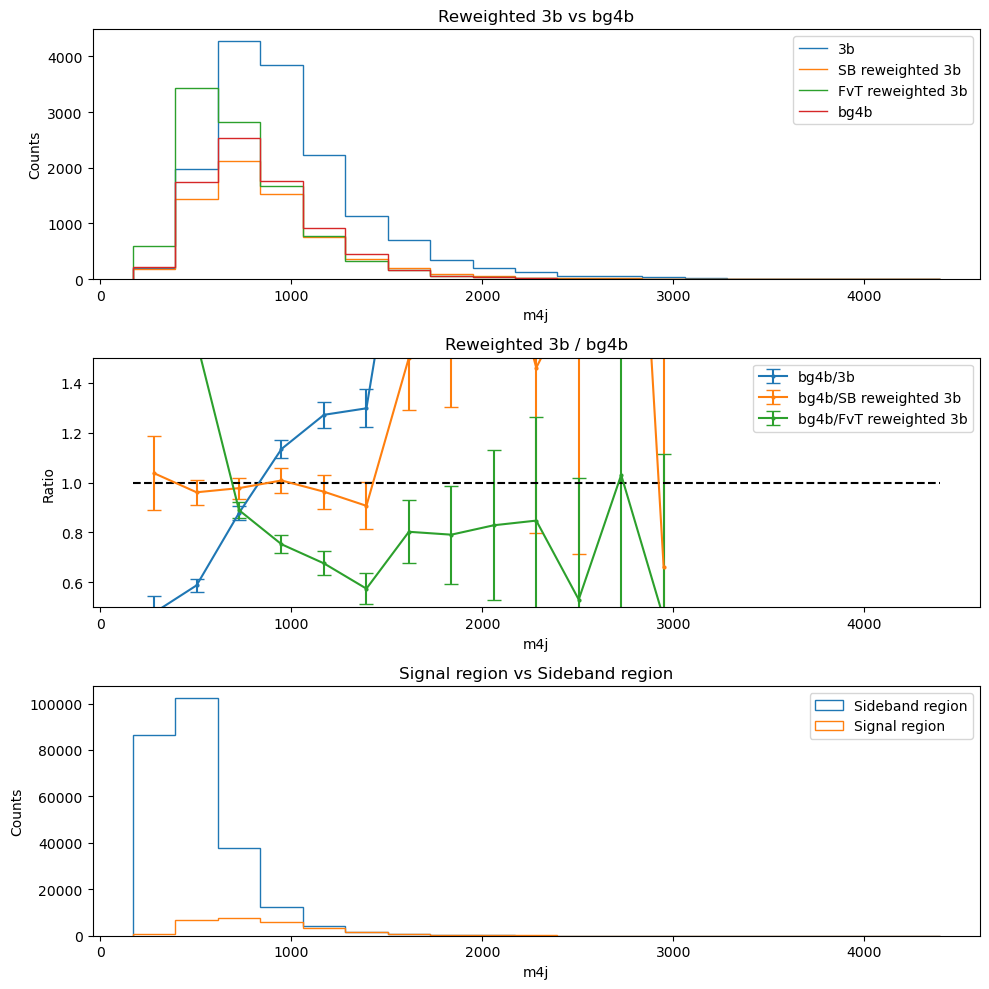

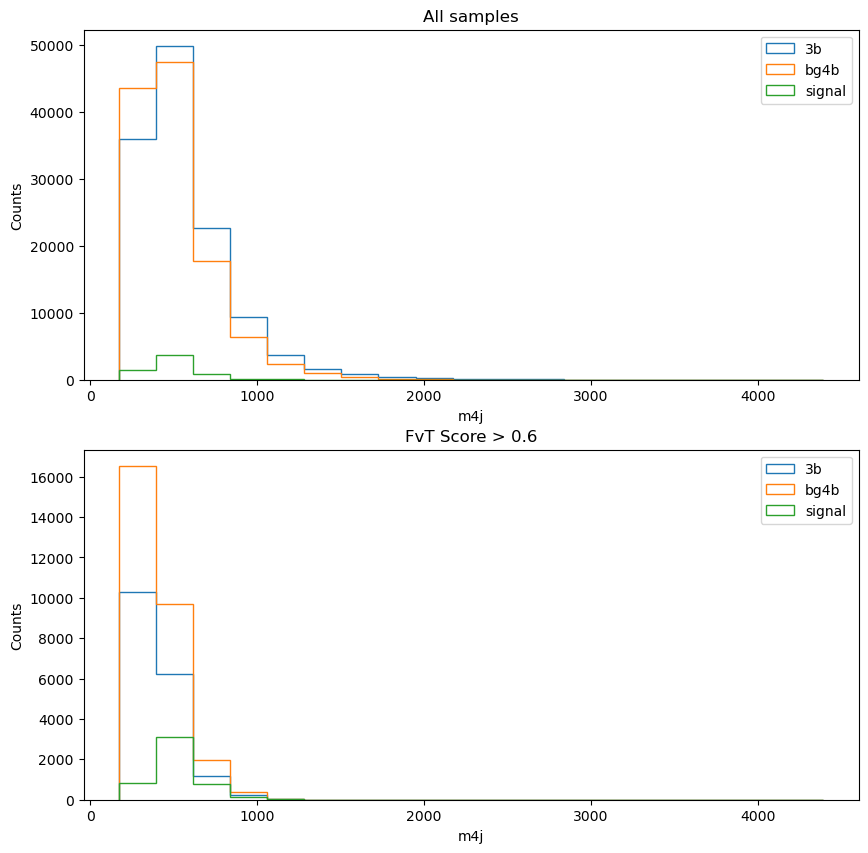

In [ ]:
plot_reweighting(get_m4j(torch.tensor(events_test.X_torch, dtype=torch.float32)), "m4j", geom=False)

/tmp/ipykernel_8289/287955892.py:61: RuntimeWarning: invalid value encountered in divide
  err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
/tmp/ipykernel_8289/287955892.py:62: RuntimeWarning: invalid value encountered in divide
  err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
/tmp/ipykernel_8289/287955892.py:63: RuntimeWarning: invalid value encountered in divide
  err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b
/tmp/ipykernel_8289/287955892.py:77: RuntimeWarning: invalid value encountered in divide
  scale_3b * hist_3b / hist_bg4b,
/tmp/ipykernel_8289/287955892.py:86: RuntimeWarning: invalid value encountered in divide
  scale_rwsb3b * hist_rwsb3b / hist_bg4b,
/tmp/ipykernel_8289/287955892.py:95: RuntimeWarning: invalid value encountered in divide
  scale_rwfvt3b * hist_rwfvt3b / hist_bg4b,


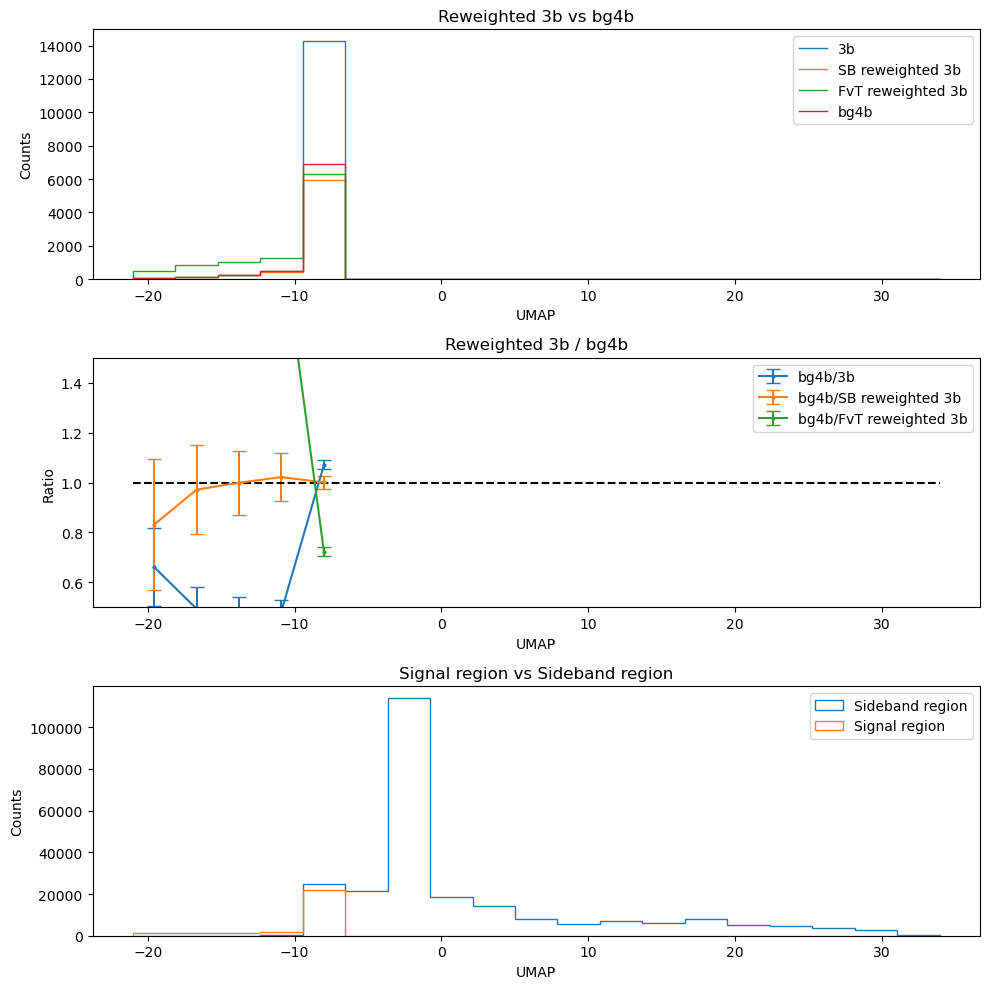

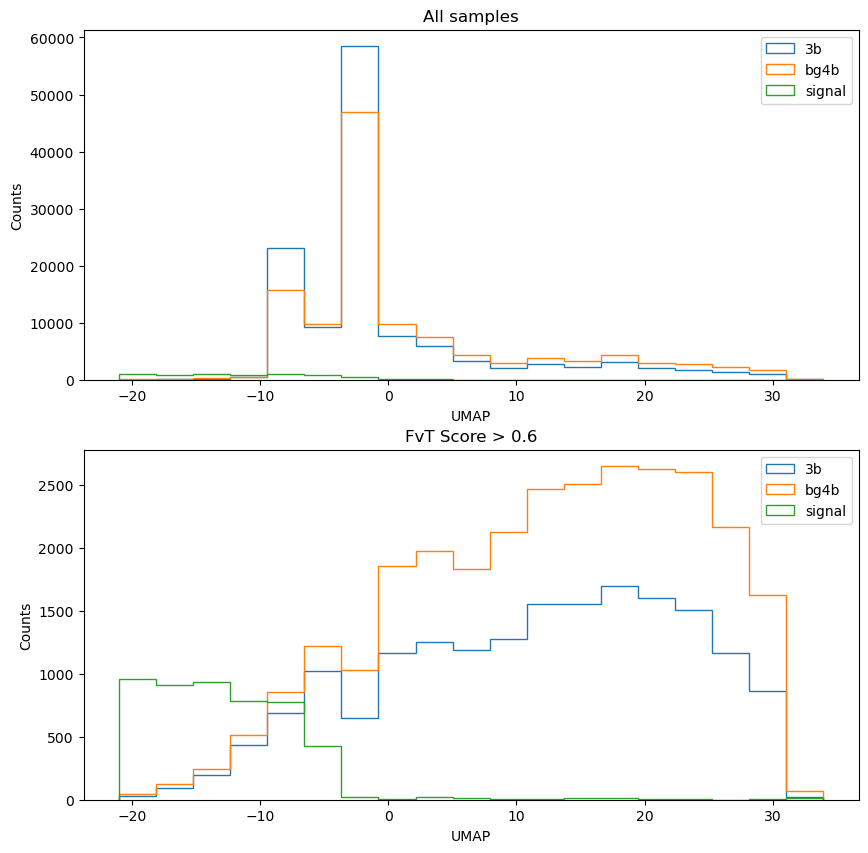

In [ ]:
plot_reweighting(events_test.npd["cluster_embed"][:, 0], "UMAP", geom=False)

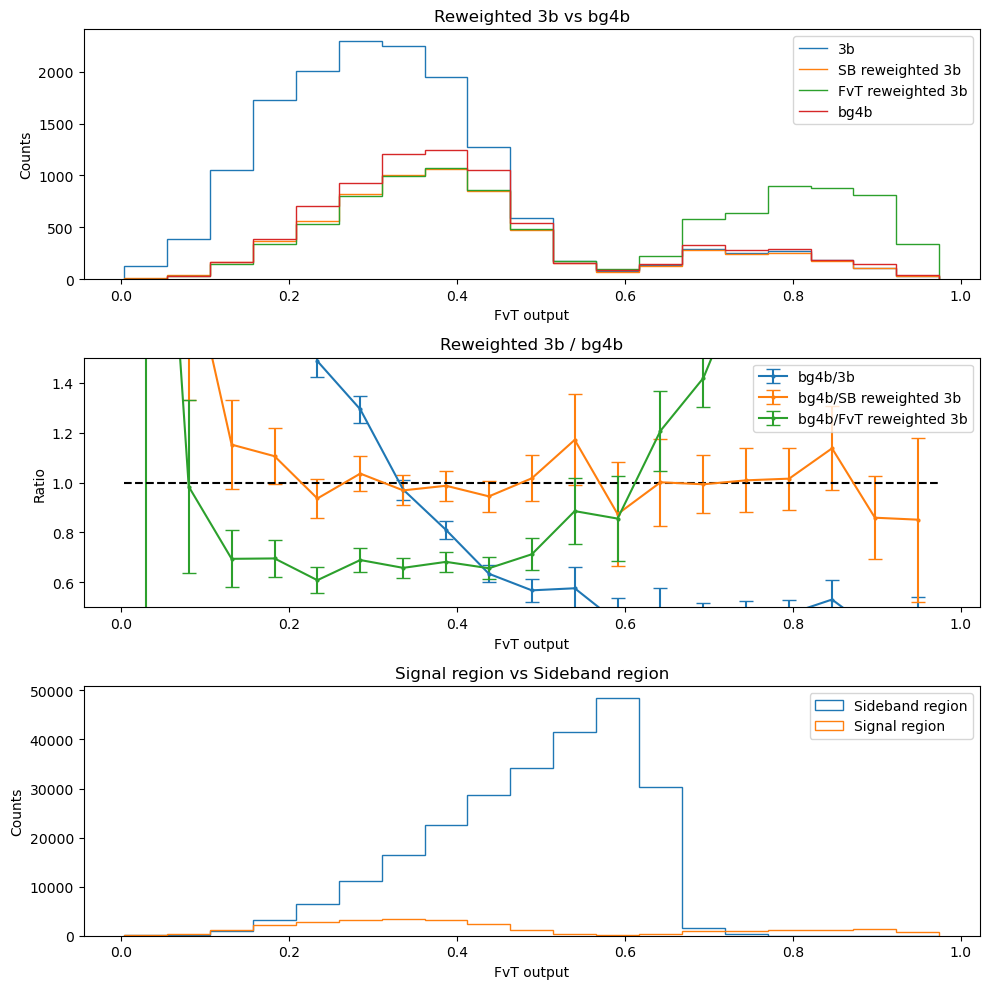

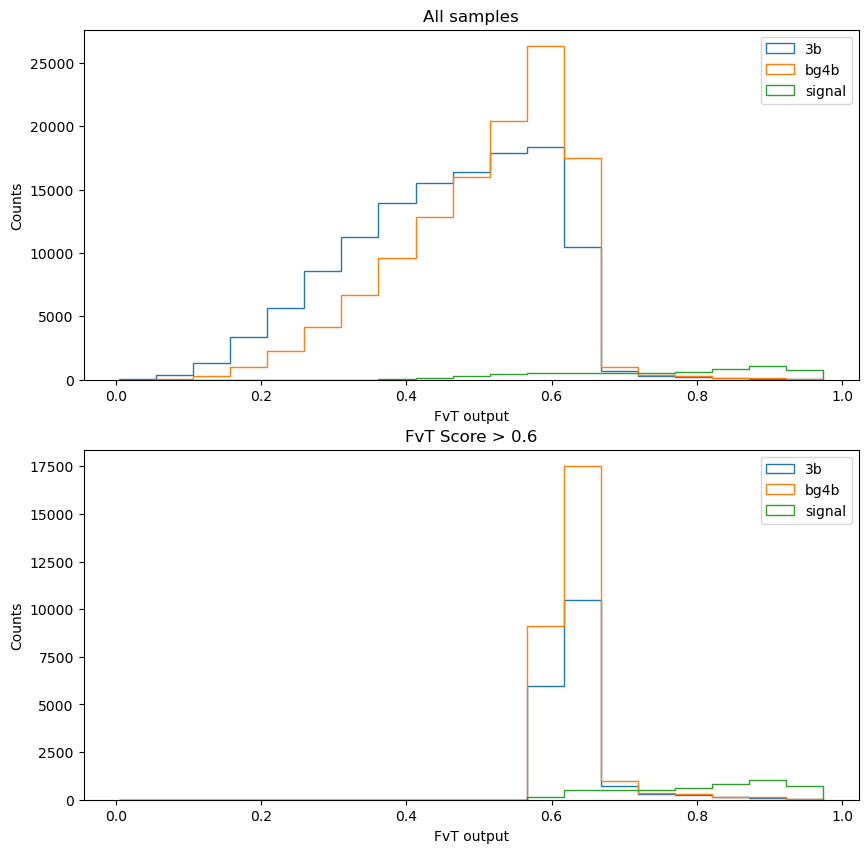

In [ ]:
plot_reweighting(events_test.fvt_score, "FvT output", geom=False)

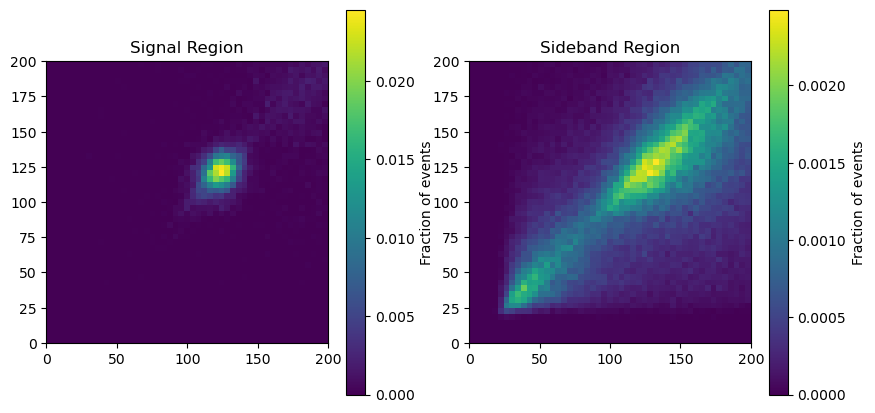

In [ ]:
from ancillary_features import jets_to_dijets


jet0 = events_test.X_torch[:, [4*i for i in range(4)]]
jet1 = events_test.X_torch[:, [4*i + 1 for i in range(4)]]
jet2 = events_test.X_torch[:, [4*i + 2 for i in range(4)]]
jet3 = events_test.X_torch[:, [4*i + 3 for i in range(4)]]

dijet01, dijet23, dijet02, dijet13, dijet03, dijet12 = jets_to_dijets(jet0, jet1, jet2, jet3, dim=2)
M01, M23, M02, M13, M03, M12 = dijet01[:, 3], dijet23[:, 3], dijet02[:, 3], dijet13[:, 3], dijet03[:, 3], dijet12[:, 3]
M01, M23, M02, M13, M03, M12 = M01.cpu().numpy(), M23.cpu().numpy(), M02.cpu().numpy(), M13.cpu().numpy(), M03.cpu().numpy(), M12.cpu().numpy()

m_diff = np.stack(
    [M01 - M23, M02 - M13, M03 - M12],
    axis=1
)
m_diff_argmin = np.argmin(np.abs(m_diff), axis=1)

m_0 = np.where(m_diff_argmin == 0, M01, np.where(m_diff_argmin == 1, M02, M03))
m_1 = np.where(m_diff_argmin == 0, M23, np.where(m_diff_argmin == 1, M13, M12))

x_bins = np.linspace(0, 200, 50)
y_bins = np.linspace(0, 200, 50)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

hist_sr, _, _ = np.histogram2d(m_0[is_in_sr], m_1[is_in_sr], bins=(x_bins, y_bins), weights=w_sr)
hist_sb, _, _ = np.histogram2d(m_0[~is_in_sr & is_in_cr], m_1[~is_in_sr & is_in_cr], bins=(x_bins, y_bins), weights=w_cr)

hist_sr = hist_sr.T
hist_sb = hist_sb.T

hist_sr /= np.sum(hist_sr)
hist_sb /= np.sum(hist_sb)

im = ax[0].imshow(hist_sr, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label("Fraction of events")
ax[0].set_title("Signal Region")

im = ax[1].imshow(hist_sb, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label("Fraction of events")
ax[1].set_title("Sideband Region")


plt.show()
plt.close()


/tmp/ipykernel_8289/3667668655.py:43: RuntimeWarning: divide by zero encountered in divide
  im = ax[0, 1].imshow(hist_3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
/tmp/ipykernel_8289/3667668655.py:43: RuntimeWarning: invalid value encountered in divide
  im = ax[0, 1].imshow(hist_3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
/tmp/ipykernel_8289/3667668655.py:48: RuntimeWarning: divide by zero encountered in divide
  im = ax[1, 0].imshow(hist_rwsb3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
/tmp/ipykernel_8289/3667668655.py:48: RuntimeWarning: invalid value encountered in divide
  im = ax[1, 0].imshow(hist_rwsb3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0

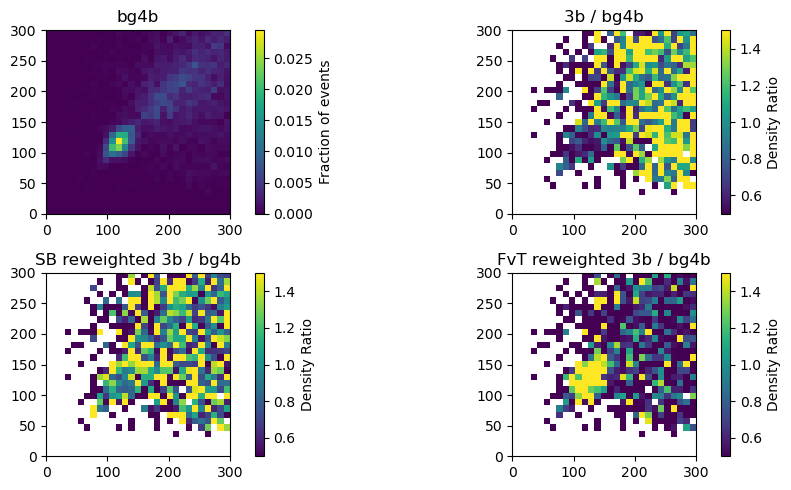

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

total_3b_sb = np.sum(w_cr[is_3b_cr])
total_4b_sb = np.sum(w_cr[is_4b_cr])

total_3b_sr = np.sum(w_sr[is_3b_sr])
total_4b_sr = np.sum(w_sr[is_4b_sr])

total_3b_fvt = np.sum(w_test[is_3b_test])
total_4b_fvt = np.sum(w_test[is_4b_test])

sb_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_sb / total_3b_sb)
fvt_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_fvt / total_3b_fvt)

reweights_sb_sr = w_sr * np.where(
    is_3b_sr, sb_reweight_const * (fvt_score_new / (1 - fvt_score_new)), 1
)
reweights_fvt_sr = w_sr * np.where(
    is_3b_sr, fvt_reweight_const * (fvt_score_orig / (1 - fvt_score_orig)), 1
)

m_0_sr = m_0[is_in_sr]
m_1_sr = m_1[is_in_sr]

x_bins = np.linspace(0, 300, 30)
y_bins = np.linspace(0, 300, 30)

hist_bg4b_sr, _, _ = np.histogram2d(m_0_sr[is_bg4b_sr], m_1_sr[is_bg4b_sr], bins=(x_bins, y_bins), weights=w_sr[is_bg4b_sr])
hist_3b_sr, _, _ = np.histogram2d(m_0_sr[is_3b_sr], m_1_sr[is_3b_sr], bins=(x_bins, y_bins), weights=w_sr[is_3b_sr])
hist_rwsb3b_sr, _, _ = np.histogram2d(m_0_sr[is_3b_sr], m_1_sr[is_3b_sr], bins=(x_bins, y_bins), weights=reweights_sb_sr[is_3b_sr])
hist_rwfvt3b_sr, _, _ = np.histogram2d(m_0_sr[is_3b_sr], m_1_sr[is_3b_sr], bins=(x_bins, y_bins), weights=reweights_fvt_sr[is_3b_sr])

hist_bg4b_sr /= np.sum(hist_bg4b_sr)
hist_3b_sr /= np.sum(hist_3b_sr)
hist_rwsb3b_sr /= np.sum(hist_rwsb3b_sr)
hist_rwfvt3b_sr /= np.sum(hist_rwfvt3b_sr)

im = ax[0, 0].imshow(hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
cbar = plt.colorbar(im, ax=ax[0, 0])
cbar.set_label("Fraction of events")
ax[0, 0].set_title("bg4b")

im = ax[0, 1].imshow(hist_3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
cbar = plt.colorbar(im, ax=ax[0, 1])
cbar.set_label("Density Ratio")
ax[0, 1].set_title("3b / bg4b")

im = ax[1, 0].imshow(hist_rwsb3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
cbar = plt.colorbar(im, ax=ax[1, 0])
cbar.set_label("Density Ratio")
ax[1, 0].set_title("SB reweighted 3b / bg4b")

im = ax[1, 1].imshow(hist_rwfvt3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
cbar = plt.colorbar(im, ax=ax[1, 1])
cbar.set_label("Density Ratio")
ax[1, 1].set_title("FvT reweighted 3b / bg4b")

plt.tight_layout()
plt.show()
plt.close()